In [ ]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import kmedoids
from helper import plot_dbscan_grid

warnings.filterwarnings('ignore')

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Notes

- K-means already performs really well, which does not show the usefulness of K-Medoids -> maybe different dataset
- I also applied the clustering algorithms on the UMAP reduced data instead for cleaner results. We can change this, then the results won't be as clean and we probably see more differences in the tools, but it maybe is also less intuitive
- The method to choose a good epsilon in DBSCAN is somewhat not reliable in the Wine example, because a higher epsilon obviously worked better
- TODO: Maybe add the K-Distance graph to figure out good values? DBSCAN -> breast cancer ds
- We should also show how to deal with mixed (including also categorical data) when doing clustering -> where?
- TODO: Do we want to apply SMOTE for same sample of each group?

<br><br>
# **Table of Contents**
- [Notes](#notes)
- [Hands-On: Clustering](#hands-on-clustering)
  - [Introduction to the Wine Dataset](#introduction-to-the-wine-dataset)
- [K-Means/K-Medoids Clustering](#k-meansk-medoids-clustering)
  - [From K-Means to K-Medoids](#from-k-means-to-k-medoids)
  - [K-Means vs K-Medoids: Comparison](#k-means-vs-k-medoids-comparison)
- [Hierarchical Clustering](#hierarchical-clustering)
  - [Ward's Method](#wards-method)
  - [How to Read Dendrograms](#how-to-read-dendrograms)
  - [Single Linkage Method](#single-linkage-method)
  - [Complete Linkage Method](#complete-linkage-method)
  - [Average Linkage Method](#average-linkage-method)
  - [Hierarchical Clustering Overview](#hierarchical-clustering-overview)
- [Density-Based Spatial Clustering of Applications with Noise (DBSCAN) Clustering](#density-based-spatial-clustering-of-applications-with-noise-dbscan-clustering)
  - [Understanding the K-Distance Graph](#understanding-the-k-distance-graph)
  - [DBSCAN Parameter Effects](#dbscan-parameter-effects)
- [Clustering Methods Overview](#clustering-methods-overview)
- [Applying Clustering to Medical Data](#applying-clustering-to-medical-data)
  - [Recap Breast Cancer Wisconsin Dataset](#recap-breast-cancer-wisconsin-dataset)
  - [K-Means / K-Medoids](#k-means--k-medoids)
  - [Hierarchical Clustering](#hierarchical-clustering-1)
  - [DBSCAN](#dbscan)
  - [Overview](#overview)

<br><br>
# **Hands-On: Clustering**

## Learning Goals
By the end of this session, you will be able to:

- **Implement partitioning clustering algorithms**
  - Apply K-Means and K-Medoids clustering to discover natural groups in datasets
  - Compare centroid-based vs. medoid-based approaches and understand when to use each method

- **Master hierarchical clustering techniques**
  - Use Ward's, single, complete, and average linkage methods to build cluster hierarchies
  - Read and interpret dendrograms to determine optimal cluster numbers and relationships

- **Apply density-based clustering methods**
  - Implement DBSCAN to identify clusters of varying shapes and detect outliers
  - Tune parameters using K-distance graphs and understand effects on cluster formation

## Introduction to the Wine Dataset

The **Wine Recognition dataset** is a classic dataset in machine learning, containing chemical analysis results of wines grown in the same region of Italy but derived from three different cultivars (grape varieties).

- **Samples:** 178 wine samples
- **Features:** 13 numeric features representing chemical properties (for example alcohol content, color intensity, flavanoids etc.)
- **Labels:** 
    - `0` = Class 0 wine (59 samples)
    - `1` = Class 1 wine (71 samples) 
    - `2` = Class 2 wine (48 samples)
- **Data type:** All features are continuous, numeric (floating-point)
- **No missing values:** The dataset is complete and ready for analysis
- **Why useful for clustering:** The three wine classes have distinct chemical profiles, making them ideal for demonstrating how clustering algorithms - discover natural groupings in data

The chemical analysis approach mirrors how we might cluster patients based on blood tests, metabolic panels, or other laboratory measurements in healthcare settings.

In [28]:
# Load the dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  wine_class  
0                          3.92   1065.0           0  
1                          3.40   1050.0           0  
2                          3.17   1185.0           0  
3                          3.45   1480.0           0  
4                          2.93    735.0           0

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  wine_

In [23]:
df.describe().round(2)

alcohol  malic_acid     ash  alcalinity_of_ash  magnesium  \
count   178.00      178.00  178.00             178.00     178.00   
mean     13.00        2.34    2.37              19.49      99.74   
std       0.81        1.12    0.27               3.34      14.28   
min      11.03        0.74    1.36              10.60      70.00   
25%      12.36        1.60    2.21              17.20      88.00   
50%      13.05        1.87    2.36              19.50      98.00   
75%      13.68        3.08    2.56              21.50     107.00   
max      14.83        5.80    3.23              30.00     162.00   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count         178.00      178.00                178.00           178.00   
mean            2.30        2.03                  0.36             1.59   
std             0.63        1.00                  0.12             0.57   
min             0.98        0.34                  0.13             0.41   
25%             1.74        1.20                  0.27             1.25   
50%             2.36        2.13                  0.34             1.56   
75%             2.80        2.88                  0.44             1.95   
max             3.88        5.08                  0.66             3.58   

       color_intensity     hue  od280/od315_of_diluted_wines  proline  \
count           178.00  178.00                        178.00   178.00   
mean              5.06    0.96                          2.61   746.89   
std               2.32    0.23                          0.71   314.91   
min               1.28    0.48                          1.27   278.00   
25%               3.22    0.78                          1.94   500.50   
50%               4.69    0.96                          2.78   673.50   
75%               6.20    1.12                          3.17   985.00   
max              13.00    1.71                          4.00  1680.00   

       wine_class  
count      178.00  
mean         0.94  
std          0.78  
min          0.00  
25%          0.00  
50%          1.00  
75%          2.00  
max          2.00

In [24]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
wine_class                      0
dtype: int64

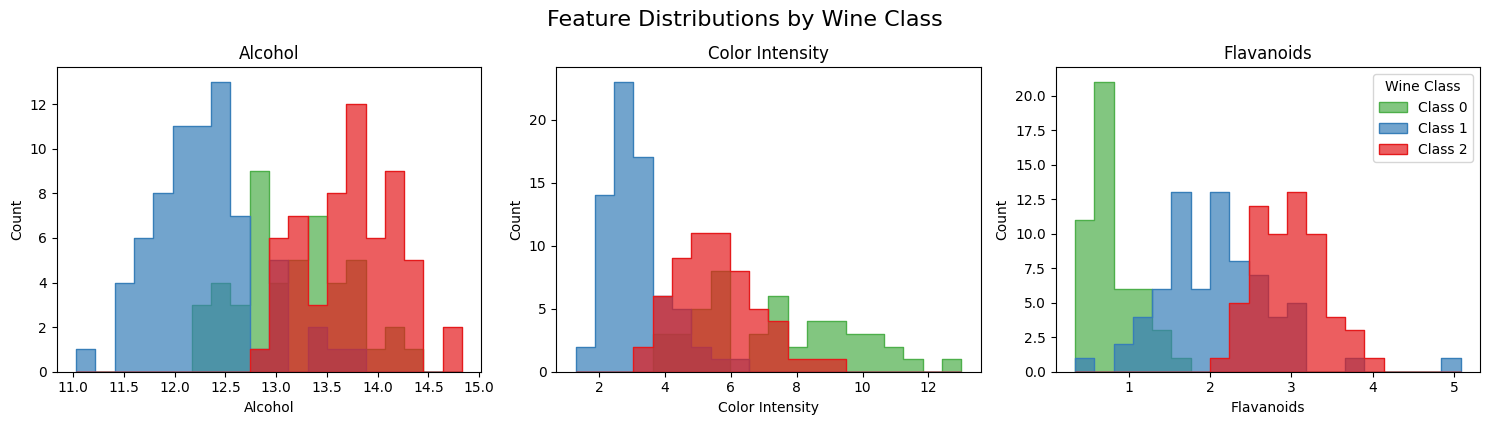

In [ ]:
# Create DataFrame for easier plotting
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

# Visualize distributions of key features, colored by wine class
plt.figure(figsize=(15, 4))
for i, feat in enumerate(['alcohol', 'color_intensity', 'flavanoids']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feat, hue='wine_class', palette='Set1', bins=20, alpha=0.7, 
                 legend=(i==2), element="step")
    plt.title(feat.replace('_', ' ').title())
    plt.xlabel(feat.replace('_', ' ').title())
    plt.ylabel('Count')
    if i == 2:
        plt.legend(labels=[f'Class {i}' for i in range(3)], title='Wine Class')
plt.tight_layout()
plt.suptitle("Feature Distributions by Wine Class", fontsize=16, y=1.05)
plt.show()

<br><br>
# **K-Means/K-Medoids Clustering**

**K-Means Clustering** is a simple and popular approach for partitioning a dataset into *K* distinct, non-overlapping clusters. It's one of the most widely used unsupervised learning algorithms in data science.

## Key Characteristics
- **Must specify K beforehand** - You need to decide how many clusters to find
- **Centroid-based** - Each cluster is represented by its center point (centroid)
- **Iterative algorithm** - Repeats steps until convergence
- **Goal** - Minimize the within-cluster variation and maximize the between-cluster variation
- **Assumes spherical clusters** - Works best when clusters are roughly round and similar sizes
- **Sensitive to outliers** - Extreme values can significantly affect cluster centers

## Dataset for Demonstration

To understand how K-Means works, we'll create a **simulated 2D dataset** with known cluster structure. We'll generate 300 data points distributed across 4 natural clusters, then demonstrate how to discover this structure using clustering algorithms. Feel free to adjust the parameters to experiment!


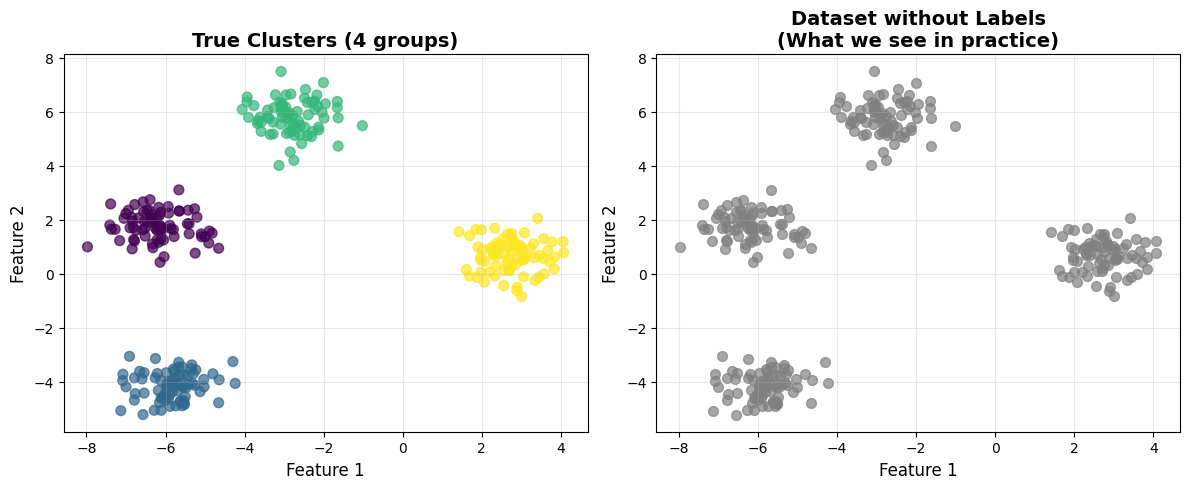

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

# Parameters for the dataset
n_samples = 300
n_features = 2
centers = 4

# Generate a clean 2D dataset with 4 clusters
X_clean, y_true = make_blobs(
    n_samples=n_samples, 
    centers=centers, 
    n_features=n_features,
    cluster_std=0.6,
    center_box=(-8.0, 8.0),
    random_state=43
)

# Create DataFrame for easier handling
df_clean = pd.DataFrame(X_clean, columns=['Feature_1', 'Feature_2'])
df_clean['true_cluster'] = y_true

# Visualize the clean dataset
plt.figure(figsize=(12, 5))

# Plot 1: True clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50)
plt.title('True Clusters (4 groups)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot 2: All points (no color coding)
plt.subplot(1, 2, 2)
plt.scatter(X_clean[:, 0], X_clean[:, 1], alpha=0.7, s=50, color='gray')
plt.title('Dataset without Labels\n(What we see in practice)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Finding the Right Number of Clusters: The Elbow Method

Before applying K-Means, we need to determine the optimal number of clusters *K*. The **Elbow Method** helps us find this sweet spot:

- **Run K-Means** for different values of K (e.g., 1 to 10)
- **Calculate WCSS** (Within-Cluster Sum of Squares) for each K, this shows how tightly grouped the data points are within each cluster
- **Plot the results** and look for the "elbow" - where adding more clusters gives diminishing returns
- **Choose K** at the elbow point where the curve starts to flatten

The elbow represents the optimal balance between model complexity and clustering quality.

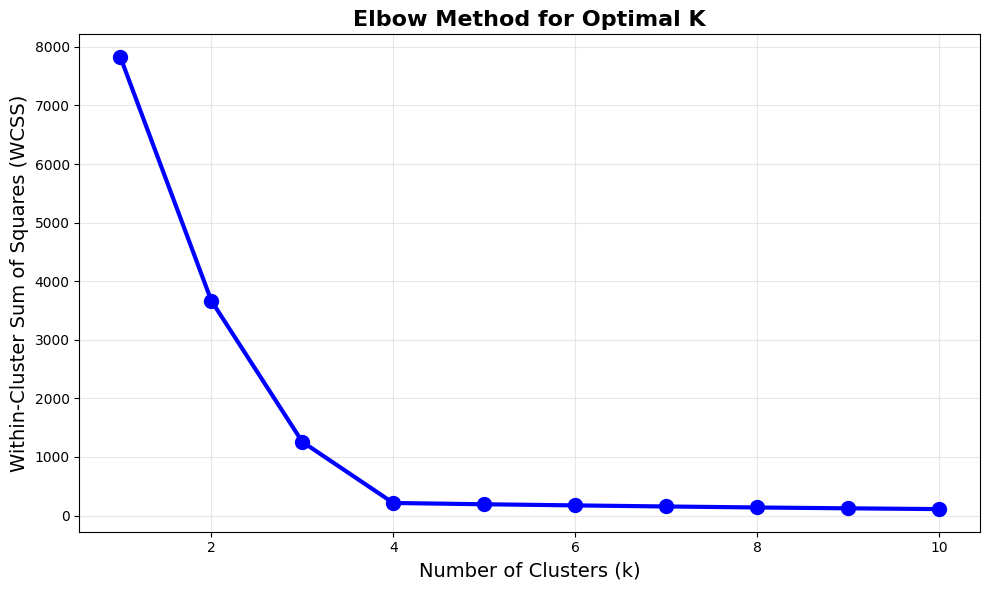

In [111]:
# Elbow Method to find optimal number of clusters
k_range = range(1, 11)
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clean)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linewidth=3, markersize=10, color='blue')
plt.title('Elbow Method for Optimal K', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Looking at the plot, we see clearly a diminishing return at 3/4 clusters. These would be ideal values to choose as numbers of clusters when running K-Means. Now that we found a suitable *K* for our dataset, let's look in detail how K-Means actually works.

## How K-Means Works:

**Step 1: Initialize**
- Choose *K* random starting points as initial cluster centroids
- Common methods: random points, K-means++ (smarter initialization)

**Step 2: Assignment**
- For each data point, calculate distance to all centroids
- Assign each point to the closest centroid's cluster

**Step 3: Update**
- Calculate the mean (centroid) of all points in each cluster
- Move the centroid to this new mean position

**Step 4: Repeat**
- Repeat steps 2-3 until convergence:
  - Centroids stop moving significantly, OR
  - Cluster assignments stop changing, OR
  - Maximum iterations reached

Let's see how well K-Means performs on our dataset and visualize the clustering process step by step!

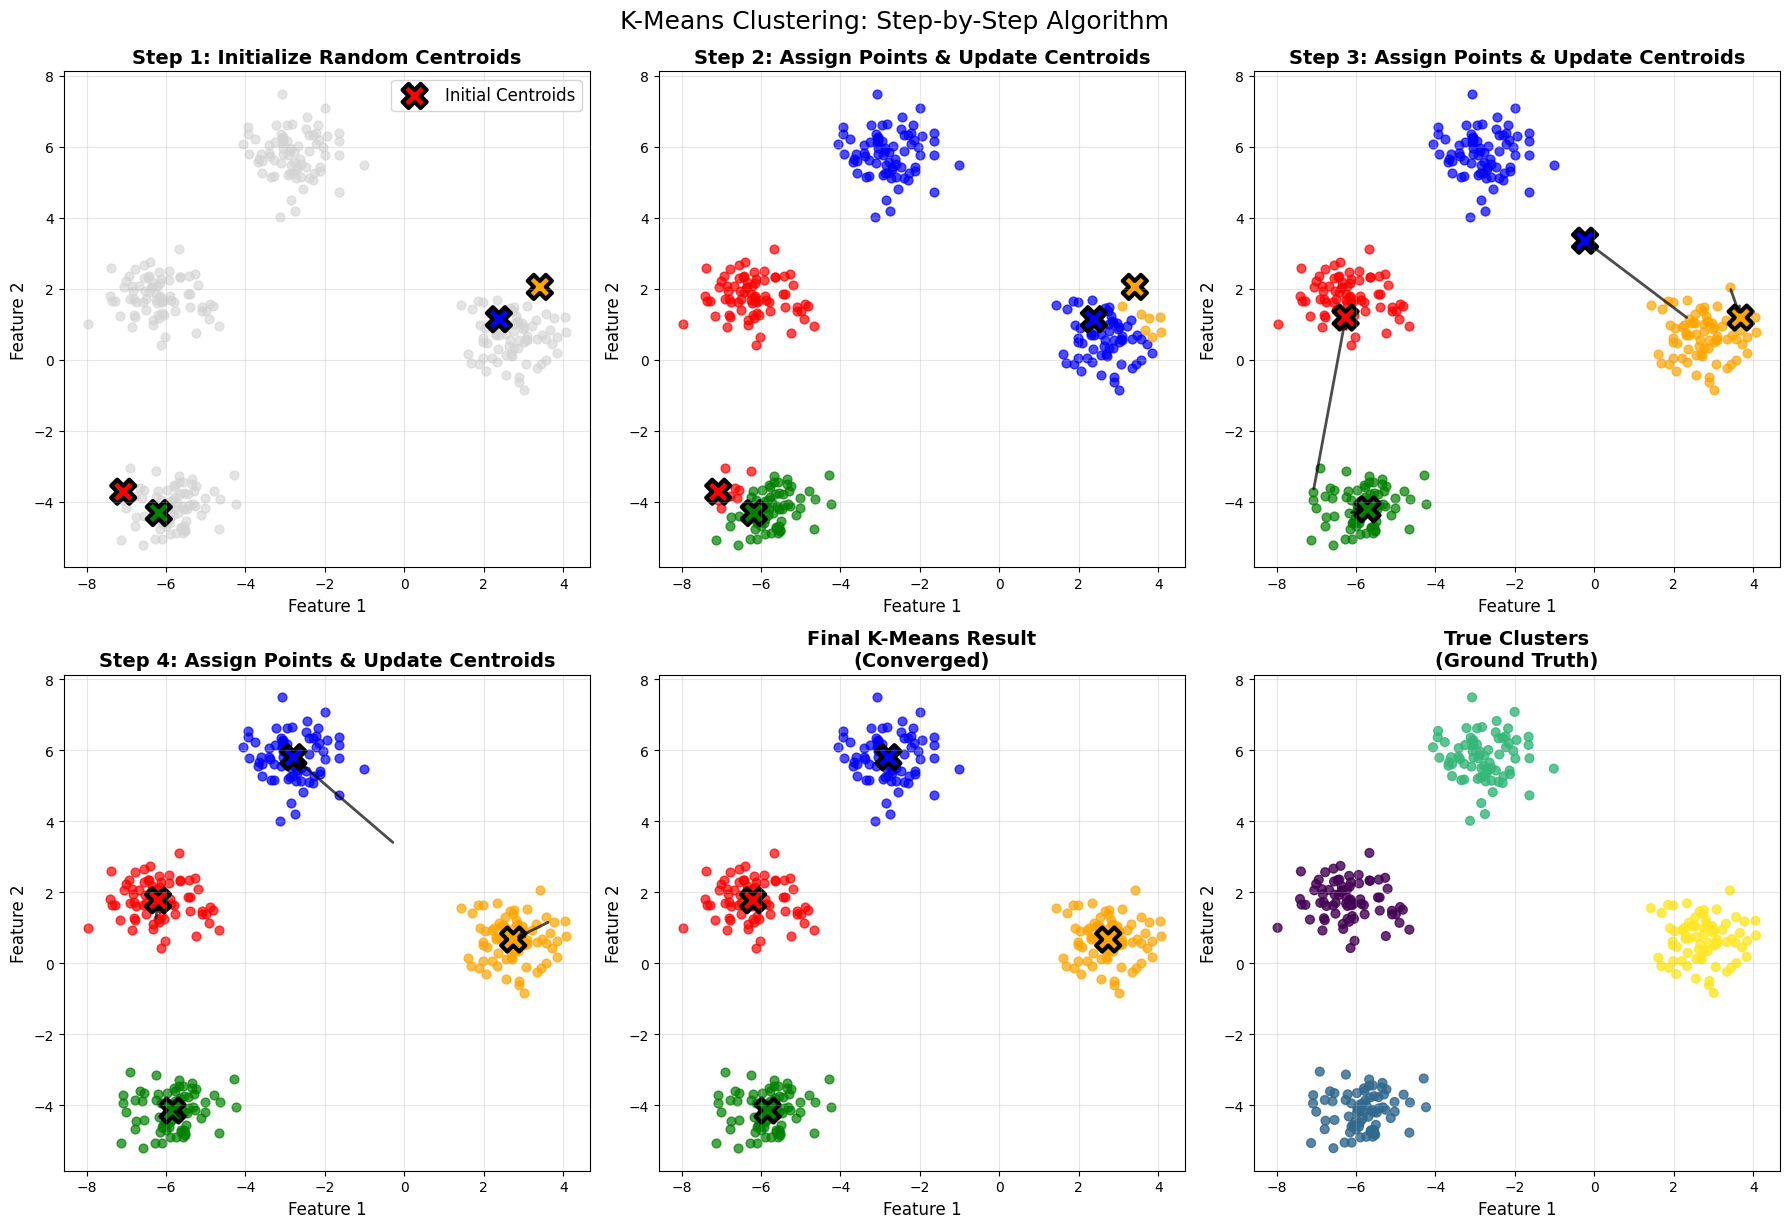

In [112]:
# Manual K-Means implementation for step-by-step visualization
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def assign_clusters(X, centroids):
    clusters = []
    for point in X:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(X, clusters, k):
    centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
        else:
            centroid = X[np.random.randint(0, len(X))]  # Handle empty clusters
        centroids.append(centroid)
    return np.array(centroids)

# Initialize K=4 random centroids (we know there are 4 true clusters)
np.random.seed(40)
k = 4
initial_centroids = X_clean[np.random.choice(X_clean.shape[0], k, replace=False)]

# Colors for visualization
colors = ['red', 'blue', 'green', 'orange']

# Step-by-step K-Means
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

centroids = initial_centroids.copy()
all_centroids_history = [centroids.copy()]  # Track centroid movement

for iteration in range(6):
    
    if iteration == 0:
        # Initial state
        axes[iteration].scatter(X_clean[:, 0], X_clean[:, 1], c='lightgray', s=40, alpha=0.6)
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=300, marker='X', 
                              edgecolors='black', linewidth=3, label='Initial Centroids')
        axes[iteration].set_title('Step 1: Initialize Random Centroids', fontsize=14, fontweight='bold')
        axes[iteration].legend(fontsize=12)
        
    elif iteration <= 3:
        # Assign points to clusters
        clusters = assign_clusters(X_clean, centroids)
        
        # Plot points colored by cluster assignment
        for i in range(k):
            mask = clusters == i
            if np.any(mask):
                axes[iteration].scatter(X_clean[mask, 0], X_clean[mask, 1], c=colors[i], s=40, alpha=0.7, 
                                      label=f'Cluster {i}')
        
        # Plot current centroids
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=300, marker='X', 
                              edgecolors='black', linewidth=3)
        
        # Show centroid movement with arrows (except first iteration)
        if iteration > 1 and len(all_centroids_history) > 1:
            old_centroids = all_centroids_history[-2]
            for i in range(k):
                axes[iteration].annotate('', xy=centroids[i], xytext=old_centroids[i],
                                       arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.7))
        
        axes[iteration].set_title(f'Step {iteration + 1}: Assign Points & Update Centroids', 
                                fontsize=14, fontweight='bold')
        
        # Update centroids for next iteration
        if iteration < 3:
            centroids = update_centroids(X_clean, clusters, k)
            all_centroids_history.append(centroids.copy())
            
    elif iteration == 4:
        # Final K-means result
        final_clusters = assign_clusters(X_clean, centroids)
        for i in range(k):
            mask = final_clusters == i
            if np.any(mask):
                axes[iteration].scatter(X_clean[mask, 0], X_clean[mask, 1], c=colors[i], s=40, alpha=0.7)
        
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=300, marker='X', 
                              edgecolors='black', linewidth=3)
        axes[iteration].set_title('Final K-Means Result\n(Converged)', fontsize=14, fontweight='bold')
        
    else:
        # Show true clusters for comparison
        scatter = axes[iteration].scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', s=40, alpha=0.8)
        axes[iteration].set_title('True Clusters\n(Ground Truth)', fontsize=14, fontweight='bold')
    
    # Formatting
    axes[iteration].set_xlabel('Feature 1', fontsize=12)
    axes[iteration].set_ylabel('Feature 2', fontsize=12)
    axes[iteration].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('K-Means Clustering: Step-by-Step Algorithm', fontsize=18, y=1.02)
plt.show()

### Key Observations

**Excellent Performance:**
- **Perfect clustering**: Successfully identified all 4 natural clusters
- **Fast convergence**: Stabilized in just 3-4 iterations
- **Accurate results**: Final clusters match ground truth perfectly

**Why K-Means Worked Well:**
- Well-separated, spherical clusters of similar sizes
- No outliers to distort the centroids
- Clean data matching K-means assumptions

Let's use KMeans now with the `Scikit-learn` package!

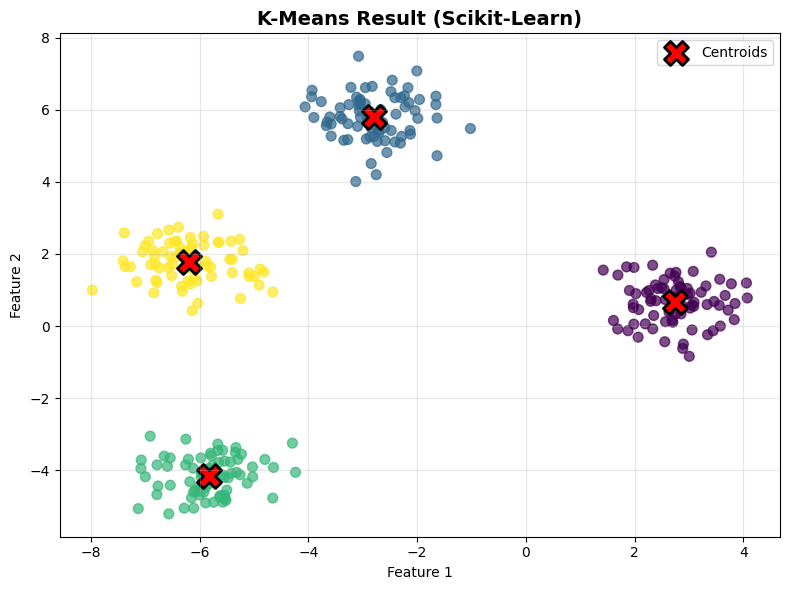

In [113]:
# Apply K-Means with k=4 (from elbow method)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_clean)
kmeans_centroids = kmeans.cluster_centers_

# Visualize results
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2, label='Centroids')
plt.title('K-Means Result (Scikit-Learn)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Measuring Cluster Quality with silhouette score

The **silhouette score** measures how well each point fits in its assigned cluster compared to other clusters. It ranges from -1 to 1:
- **Close to 1**: Point is well-matched to its cluster and far from others
- **Close to 0**: Point is on the border between clusters  
- **Negative**: Point might be in the wrong cluster

Let's visualize the silhouette scores for our K-means result:

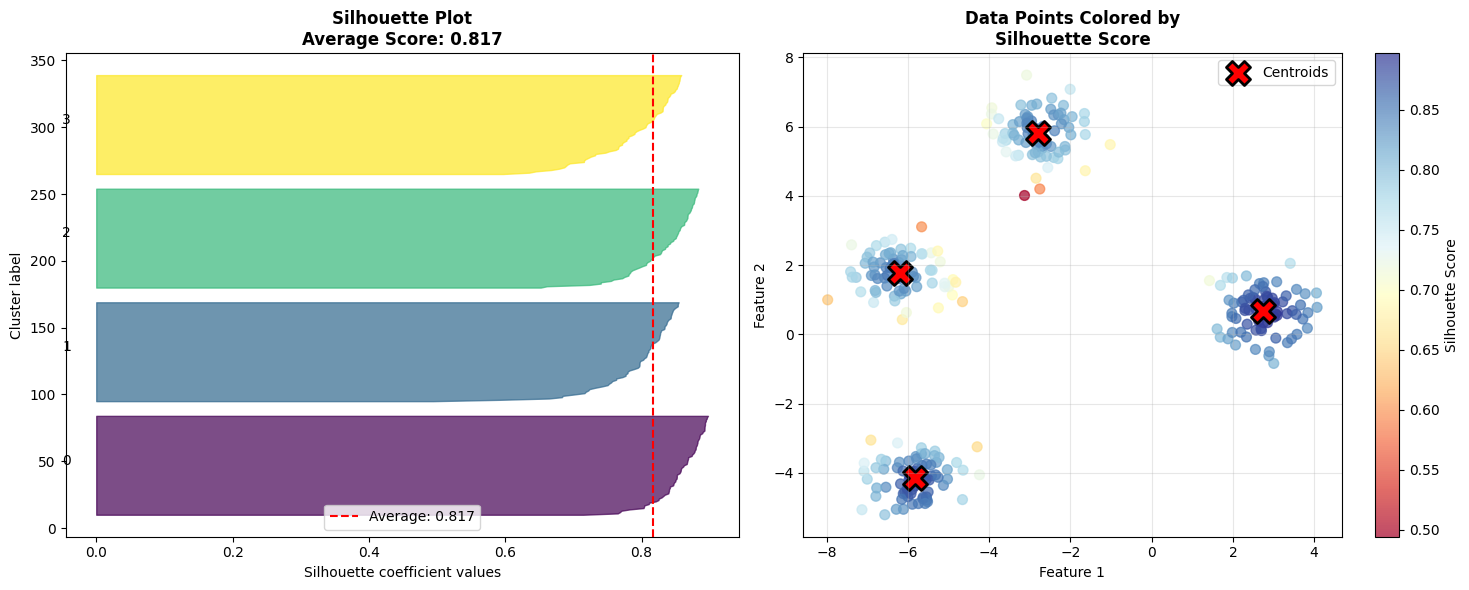

In [115]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Calculate silhouette scores
silhouette_avg = silhouette_score(X_clean, kmeans_labels)
sample_silhouette_values = silhouette_samples(X_clean, kmeans_labels)

# Create silhouette plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Silhouette plot
y_lower = 10
colors = cm.viridis(np.linspace(0, 1, 4))

for i in range(4):
    # Get silhouette scores for cluster i
    cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label clusters
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster label')
ax1.set_title(f'Silhouette Plot\nAverage Score: {silhouette_avg:.3f}', fontweight='bold')

# Add vertical line for average score
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", 
           label=f'Average: {silhouette_avg:.3f}')
ax1.legend()

# Plot 2: Clustered data with silhouette coloring
scatter = ax2.scatter(X_clean[:, 0], X_clean[:, 1], c=sample_silhouette_values, 
                     cmap='RdYlBu', alpha=0.7, s=50)
ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2, label='Centroids')
ax2.set_title('Data Points Colored by\nSilhouette Score', fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add colorbar
plt.colorbar(scatter, ax=ax2, label='Silhouette Score')

plt.tight_layout()
plt.show()

As we can see from the silhouette analysis (score: 0.817), K-means performed exceptionally well on our clean dataset. This makes sense because:

- **Well-separated clusters**: Clear gaps between groups
- **Spherical shapes**: Matches K-means assumptions  
- **No noise**: Clean, ideal conditions

However real datasets often contain outliers, noise, and messy data. Let's stress-test K-means by adding some extreme outliers and see how robust it really is...

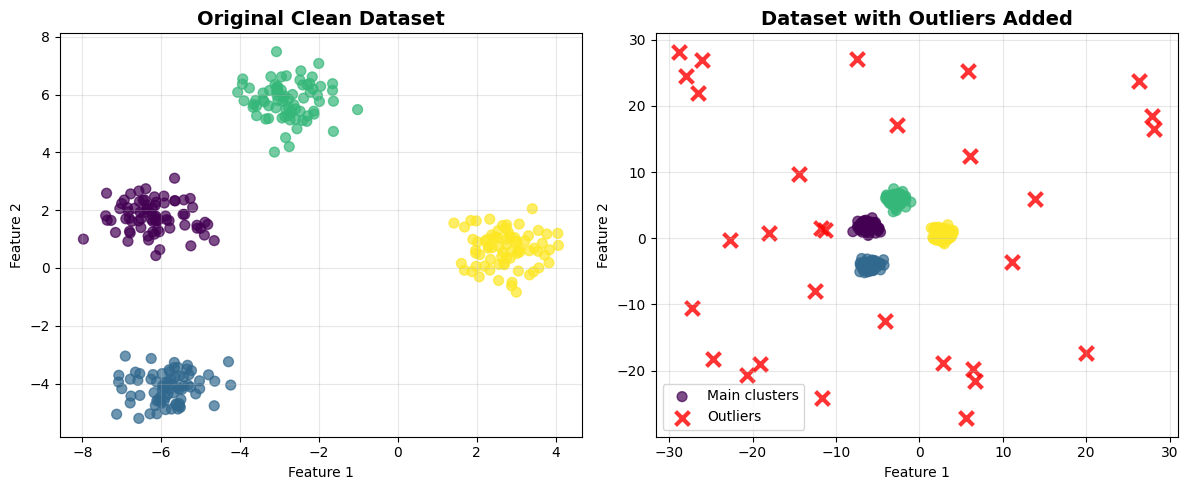

In [121]:
# Add outliers to the clean dataset
np.random.seed(42)  # Different seed for outliers
n_outliers = 30

# Generate outliers at random positions far from main clusters
outlier_range = (-30, 30)  # Wider range than main data
X_outliers = np.random.uniform(outlier_range[0], outlier_range[1], (n_outliers, 2))

# Combine clean data with outliers
X_with_outliers = np.vstack([X_clean, X_outliers])

# Create labels (original clusters + outlier label)
y_with_outliers = np.hstack([y_true, np.full(n_outliers, -1)])  # -1 for outliers

# Visualize the dataset with outliers
plt.figure(figsize=(12, 5))

# Plot 1: Clean dataset
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50)
plt.title('Original Clean Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

# Plot 2: Dataset with outliers
plt.subplot(1, 2, 2)
# Plot main clusters
scatter2 = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50, label='Main clusters')
# Plot outliers
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', marker='x', s=100, alpha=0.8, label='Outliers', linewidths=3)
plt.title('Dataset with Outliers Added', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

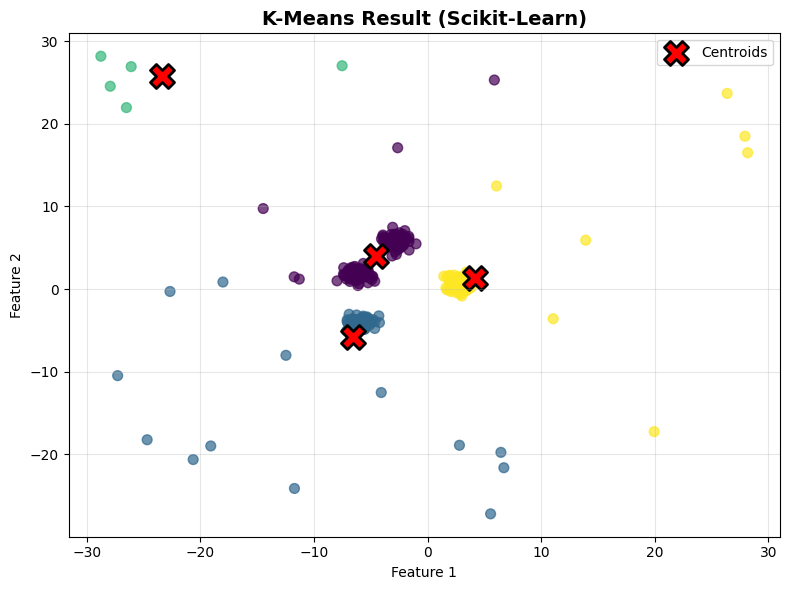

In [122]:
# Apply K-Means with k=4 (from elbow method)
kmeans = KMeans(n_clusters=4, random_state=40, n_init=10)
kmeans_labels = kmeans.fit_predict(X_with_outliers)
kmeans_centroids = kmeans.cluster_centers_

# Visualize results
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2, label='Centroids')
plt.title('K-Means Result (Scikit-Learn)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## From K-Means to K-Medoids

As we can see, K-Means is no longer able to detect the clusters properly due to the outliers, but we have a tool that can help us.

Let's explore **K-Medoids (Paritioning around medoids (PAM))** - a more robust alternative to K-Means.

### Key Differences:

- **Cluster centers**: K-Means uses calculated centroids vs K-Medoids uses actual data points (medoids)
- **Outlier sensitivity**: K-Medoids is more robust to outliers than K-Means
- **Distance metrics**: K-Medoids can use any distance metric, K-Means is limited to Euclidean

### When to Use K-Medoids:

- **Noisy data** with outliers
- **Better interpretability** - medoids are real samples
- **Non-Euclidean data** where averaging doesn't make sense

Let's apply K-Medoids to our dataset and compare the results!

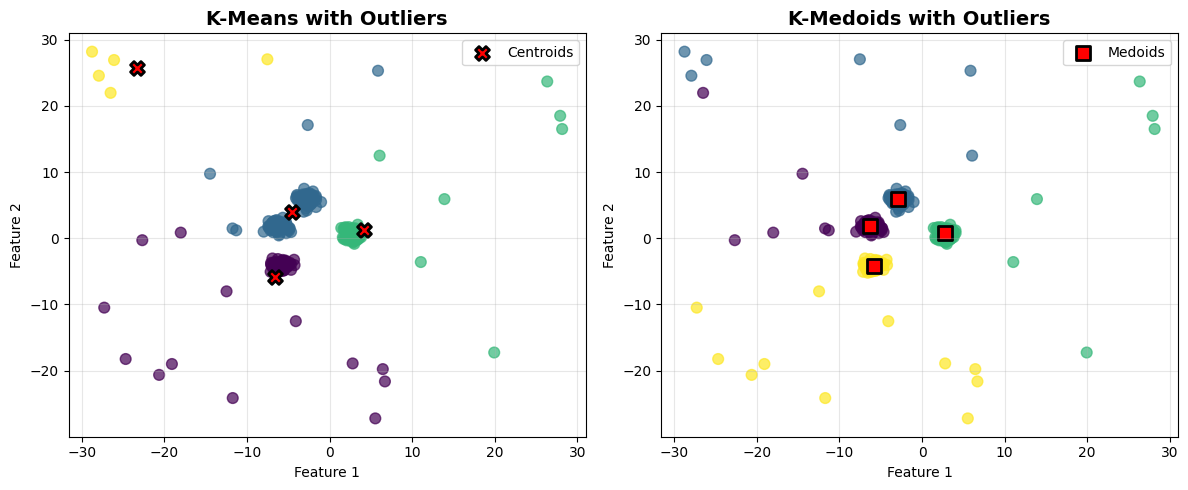

In [ ]:
# K-Medoids clustering on data with outliers
from sklearn.metrics import pairwise_distances

# Apply K-Medoids with k=3 clusters
kmed = kmedoids.KMedoids(n_clusters=4, random_state=42)
euclidean_dist = pairwise_distances(X_with_outliers, metric='euclidean')
kmed.fit(euclidean_dist)

# Get cluster labels and medoid indices
kmedoids_labels = kmed.labels_
medoid_indices = kmed.medoid_indices_
medoids = X_with_outliers[medoid_indices]

# Visualize K-Medoids results
plt.figure(figsize=(12, 5))

# Plot 1: K-Means on data with outliers (for comparison)
plt.subplot(1, 2, 1)
kmeans_outliers = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_outliers_labels = kmeans_outliers.fit_predict(X_with_outliers)
kmeans_outliers_centroids = kmeans_outliers.cluster_centers_

scatter1 = plt.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmeans_outliers_labels, 
                      cmap='viridis', alpha=0.7, s=60)
plt.scatter(kmeans_outliers_centroids[:, 0], kmeans_outliers_centroids[:, 1], 
           c='red', marker='X', s=100, edgecolors='black', linewidth=2, label='Centroids')
# Highlight outliers
outlier_mask = X_with_outliers == -1
plt.title('K-Means with Outliers', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: K-Medoids results
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmedoids_labels, 
                      cmap='viridis', alpha=0.7, s=60)
plt.scatter(medoids[:, 0], medoids[:, 1], 
           c='red', marker='s', s=100, edgecolors='black', linewidth=2, label='Medoids')
plt.title('K-Medoids with Outliers', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Perfect! Now with the extreme outliers we can clearly see that K-Medoids shines and doesn't overfit to the data!**

Notice the key differences:

- **K-Means centroids** (left plot): The red X markers are pulled away from the true cluster centers by the outliers, especially visible in the top cluster where the centroid is displaced toward the outlying points.

- **K-Medoids medoids** (right plot): The red square markers remain firmly within the actual cluster cores, as they must be real data points from the dataset. The outliers cannot "pull" the medoids away from the main clusters.

This demonstrates K-Medoids' **robustness to outliers** - a crucial advantage when dealing with real-world messy data!

## K-Means vs K-Medoids: Comparison

### Similarities:
- Both are partitional clustering methods that divide data into K clusters
- Must specify K beforehand
- Iterative algorithms with assignment and update steps
- Sensitive to initialization and assume similar cluster sizes

### Key Differences:

| Aspect | K-Means | K-Medoids |
|--------|---------|-----------|
| **Cluster Centers** | Calculated centroids | Actual data points |
| **Outlier Sensitivity** | High | Low |
| **Distance Metrics** | Euclidean only | Any metric |
| **Speed** | Faster | Slower |
| **Interpretability** | Centroids may not exist | Medoids are real samples |

### When to Use:

**K-Means:**
- Large datasets (computational efficiency)
- Clean data without outliers
- All continuous features

**K-Medoids:**
- Noisy data with outliers
- Need interpretable cluster centers
- Mixed data types or non-Euclidean distances

---
<br><br>
# **Hierarchical Clustering**

K-Means and K-Medoids require specifying the number of clusters K beforehand. **Hierarchical Clustering** offers an alternative approach that discovers the cluster structure without needing to choose K in advance.

### Key Advantages:
- **No need to specify K** - Algorithm reveals natural cluster structure
- **Dendrogram visualization** - Tree-based representation shows relationships between all data points
- **Multiple granularities** - extract different numbers of clusters from same result
- **Deterministic** - No random initialization, same result every time

### Types of Hierarchical Clustering:

**Agglomerative (Bottom-Up):**
- Start with each point as its own cluster
- Iteratively merge the two closest clusters
- Continue until all points are in one cluster
- Most common approach

**Divisive (Top-Down):**
- Start with all points in one cluster
- Iteratively split clusters into smaller ones
- Less common due to computational complexity

### How Agglomerative Clustering Works:

**Step 1: Initialize**
- Each data point starts as its own cluster (N clusters for N points)

**Step 2: Find Closest Clusters**
- Calculate distances between all cluster pairs
- Identify the two closest clusters

**Step 3: Merge**
- Combine the closest clusters into one
- Update distance matrix

**Step 4: Repeat**
- Continue merging until only one cluster remains
- Record the merge sequence in a dendrogram

There are different distance metrics that are used to compute hierarchical clusterings, in this context they are called *linkage*. We will look at 2 common ones **Ward's method** and **Average linkage**.

Let's see how hierarchical clustering reveals the structure in our dataset without outliers!

### Ward's Method

**Ward's linkage** is the most popular linkage criterion for hierarchical clustering because it creates compact, spherical clusters similar to K-Means.

#### How Ward's Method Works:
- **Objective**: Minimize the increase in within-cluster sum of squares (variance) when merging clusters
- **Strategy**: At each step, merge the two clusters that result in the smallest increase in total variance
- **Result**: Tends to create clusters of similar sizes with low internal variance
- **Balanced clusters** - Avoids creating very large or very small clusters

Now let's apply Ward's method to our wine dataset and learn how to read dendrograms!

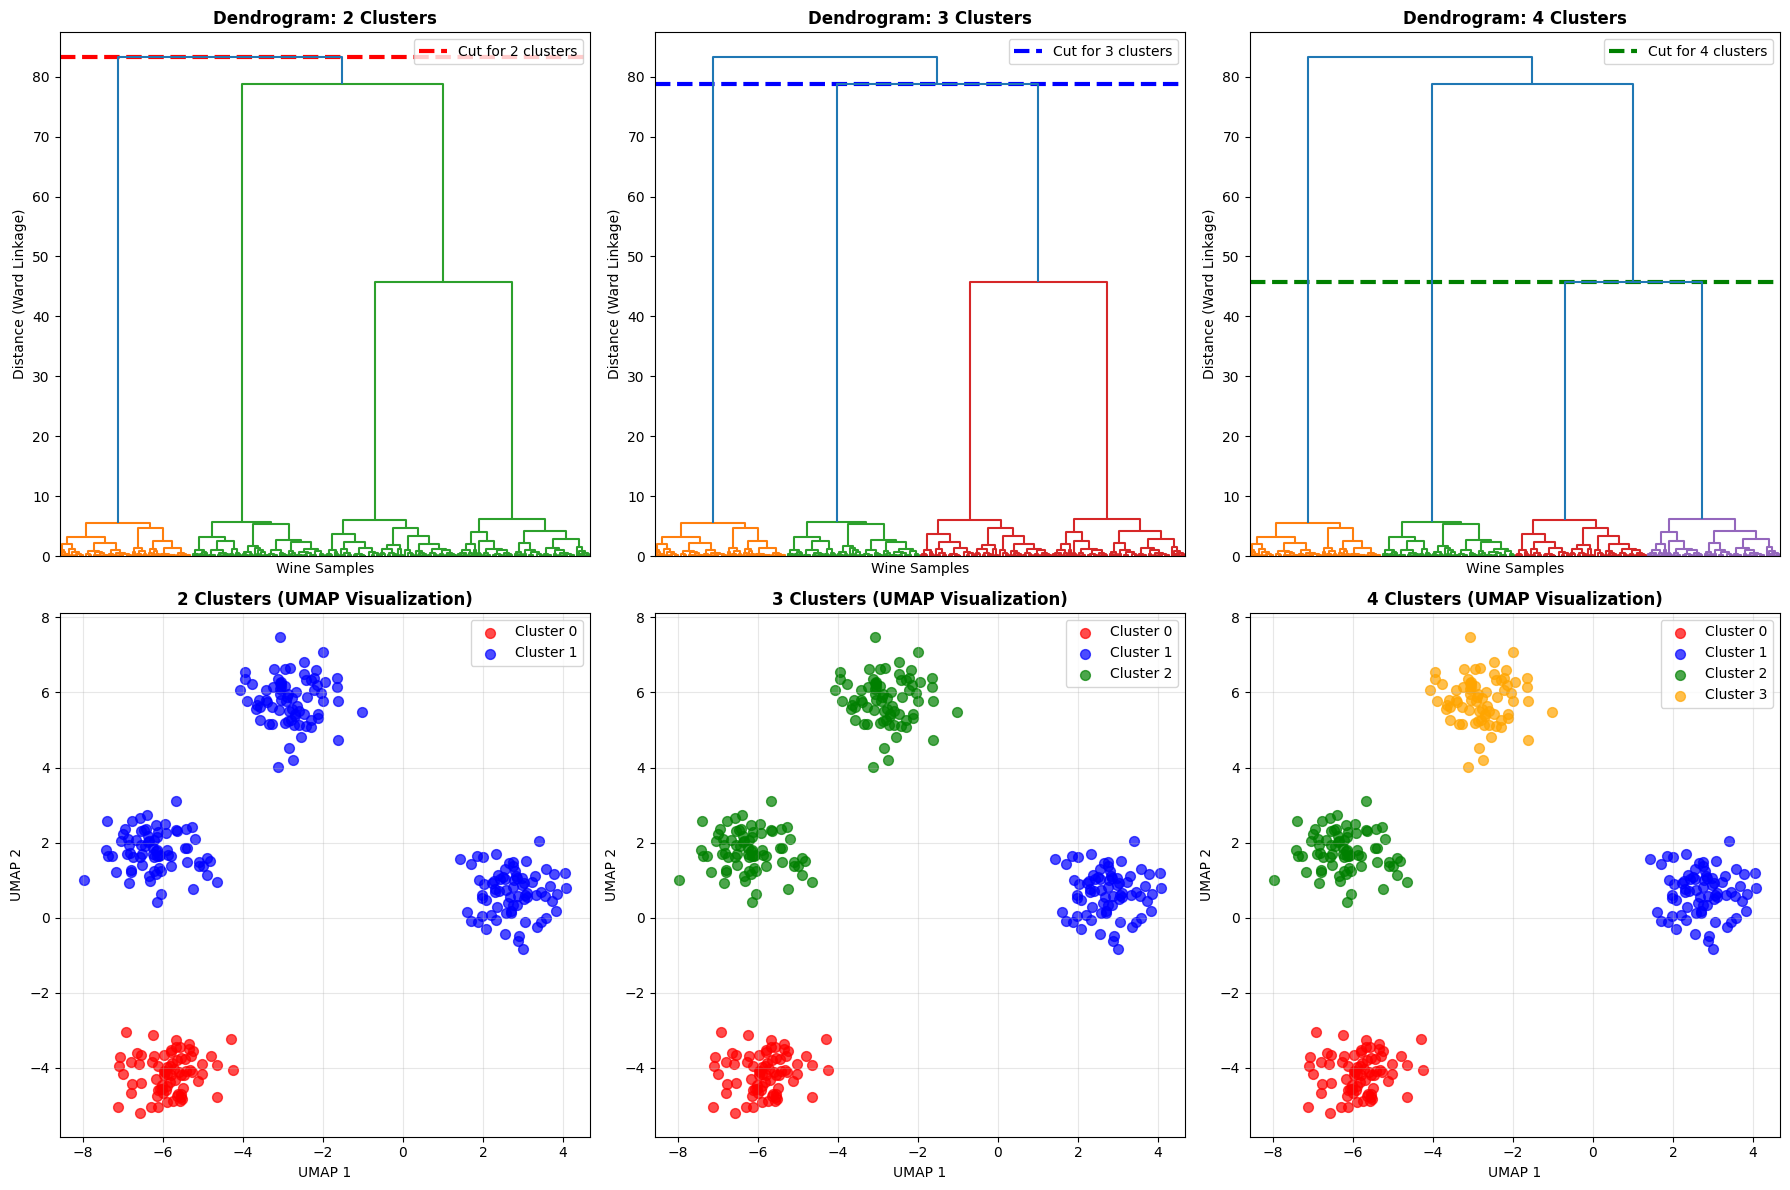

In [ ]:
# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_clean, method='ward')

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Three dendrograms with different cluster cuts
n_clusters_list = [2, 3, 4]
colors_cuts = ['red', 'blue', 'green']
cluster_colors = ['red', 'blue', 'green', 'orange']

for i, n_clusters in enumerate(n_clusters_list):
    ax = axes[0, i]
    
    # Find the distance threshold for n_clusters
    if n_clusters <= len(linkage_matrix):
        threshold = linkage_matrix[-(n_clusters-1), 2]
        ax.axhline(y=threshold, color=colors_cuts[i], linestyle='--', linewidth=3,
                  label=f'Cut for {n_clusters} clusters')
    
    # Create dendrogram
    dend = dendrogram(linkage_matrix, 
                     p=10,
                     leaf_rotation=90,
                     leaf_font_size=8,
                     show_leaf_counts=False,
                     color_threshold=threshold,
                     #link_color_func=lambda k: cluster_colors[k], evtl figure this out later
                     ax=ax)
    
    ax.set_title(f'Dendrogram: {n_clusters} Clusters', fontsize=12, fontweight='bold')
    ax.set_xlabel('Data Samples', fontsize=10)
    ax.set_ylabel('Distance (Ward Linkage)', fontsize=10)
    ax.legend(loc='upper right')
    
    # Remove x-axis tick labels
    ax.set_xticks([])

# Bottom row: Cluster visualizations for 2, 3, 4 clusters
for i, n_clusters in enumerate([2, 3, 4]):
    ax = axes[1, i]
    
    # Get cluster labels for n_clusters
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    
    # Plot points colored by cluster
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        ax.scatter(X_clean[mask, 0], X_clean[mask, 1], 
                  c=cluster_colors[cluster_id], s=50, alpha=0.7,
                  label=f'Cluster {cluster_id}')
        
    if n_clusters == 3:
        # Store results for comparison
        ward_linkage_labels = cluster_labels
        ward_linkage_matrix = linkage_matrix
    
    ax.set_title(f'{n_clusters} Clusters (UMAP Visualization)', fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## How to Read Dendrograms

### Basic Structure:
- **Y-axis (Height)**: Distance at which clusters merge - higher means more dissimilar
- **X-axis**: Individual data points
- **Branches**: Show the hierarchical relationship between samples and clusters
- **Colors**: Different colors represent different clusters at the cut level

### Key Elements:
- **Leaf nodes** (bottom): Individual data points
- **Internal nodes**: Points where clusters merge
- **Branch height**: Indicates similarity - shorter branches = more similar samples
- **Merge distance**: The height where two branches join

### Using the Cut Line:
- **Horizontal dashed line**: Shows where to "cut" the tree for desired number of clusters
- **Count clusters**: Number of vertical lines the cut line crosses
- **Cluster membership**: Samples connected below the cut belong to same cluster
- **Color coding**: Each cluster gets a different color below the cut line

### Choosing Optimal Number of Clusters:
- **Look for large jumps**: Big increases in merge distance suggest natural cluster boundaries
- **Avoid high cuts**: Don't cut where merge distances are very large
- **Compare solutions**: Use visualization plots to see which clustering makes most sense

## Average Linkage Method

**Average linkage** (also called "UPGMA") uses the average distance between all pairs of points in different clusters as the merging criterion. It is a combination of two other linkage methods (single and complete)

### How Average Linkage Works:
- **Objective**: Merge clusters with the smallest average distance between all point pairs
- **Strategy**: Calculate mean distance between every point in cluster A and every point in cluster B
- **Result**: Creates moderately compact clusters, balancing single and complete linkage extremes
- **Compromise approach** - Less sensitive to outliers than single, less conservative than complete

### Why Use Average Linkage?
- **Stable results** - Less affected by individual outlier points
- **Good general purpose** - Works well for many different cluster shapes and sizes

Let's see how Average Linkage performs!

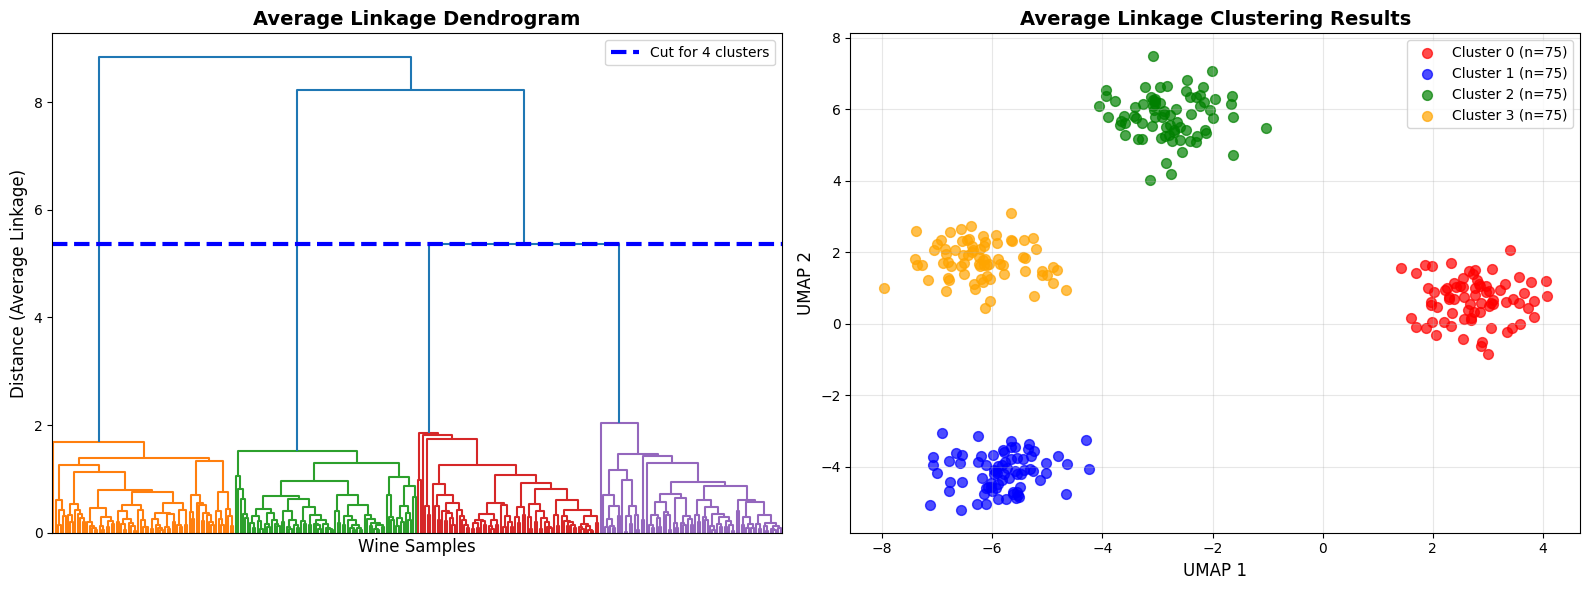

In [ ]:
# Create linkage matrix using Average Linkage method
linkage_matrix_average = linkage(X_clean, method='average')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Average Linkage Dendrogram
ax1 = axes[0]
threshold_average = linkage_matrix_average[-(4-1), 2]  # For 4 clusters

dend_average = dendrogram(linkage_matrix_average, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_average,
                        ax=ax1)

ax1.axhline(y=threshold_average, color='blue', linestyle='--', linewidth=3,
           label='Cut for 4 clusters')
ax1.set_title('Average Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Data Samples', fontsize=12)
ax1.set_ylabel('Distance (Average Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Average Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_average = fcluster(linkage_matrix_average, 4, criterion='maxclust') - 1

for cluster_id in range(4):
    mask = cluster_labels_average == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_clean[mask, 0], X_clean[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Average Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Observations - Average Linkage:

- **Well-balanced clusters**: Cluster sizes (65, 50, 63) are very evenly distributed across wine samples
- **Moderate clustering approach**: Balances between single linkage's chaining tendency and complete linkage's compactness
- **Clear separation**: Creates distinct, well-separated clusters as shown in the UMAP visualization
- **Robust to outliers**: Less sensitive to noise than single linkage while avoiding over-conservative merging

**However, we still have the same issues with noisy data.** 

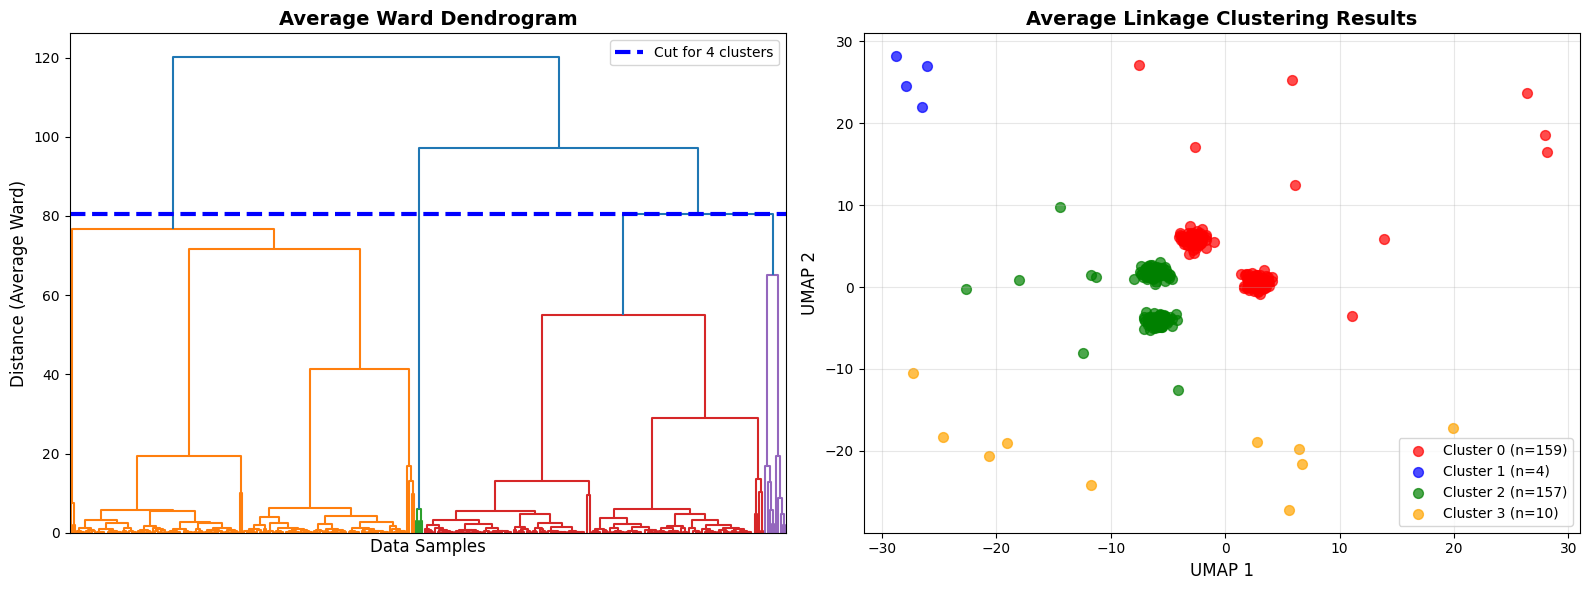

In [138]:
# Create linkage matrix using Average Linkage method
linkage_matrix_average = linkage(X_with_outliers, method='ward')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Average Linkage Dendrogram
ax1 = axes[0]
threshold_average = linkage_matrix_average[-(4-1), 2]  # For 4 clusters

dend_average = dendrogram(linkage_matrix_average, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_average,
                        ax=ax1)

ax1.axhline(y=threshold_average, color='blue', linestyle='--', linewidth=3,
           label='Cut for 4 clusters')
ax1.set_title('Average Ward Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Data Samples', fontsize=12)
ax1.set_ylabel('Distance (Average Ward)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Average Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_average = fcluster(linkage_matrix_average, 4, criterion='maxclust') - 1

for cluster_id in range(4):
    mask = cluster_labels_average == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_with_outliers[mask, 0], X_with_outliers[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Average Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Looking at the hierarchical clustering results above, we can see that even this different approach struggles with our outlier-contaminated dataset. Notice how:

- **Unbalanced clusters**: Some clusters have very few points (like Cluster 1 with only 4 points) while others are much larger
- **Outlier sensitivity**: The outliers are either forming their own tiny clusters or being incorrectly merged with main clusters
- **Inconsistent grouping**: The algorithm has difficulty distinguishing between true cluster members and noise points

This demonstrates that **outliers remain a fundamental challenge** across different clustering algorithms, not just K-Means. The hierarchical approach, while useful for understanding data structure, doesn't inherently solve the robustness problem we've been exploring.

## Hierarchical Clustering Overview

Hierarchical clustering builds a tree of clusters by iteratively merging the closest pairs. Unlike K-means, it doesn't require specifying the number of clusters beforehand and provides a complete clustering hierarchy.

### Linkage Methods Comparison

TODO: Maybe remove single and complete

| Method | Distance Calculation | Characteristics | Best For |
|--------|---------------------|-----------------|----------|
| **Single** | Minimum distance between any two points | Creates chains, sensitive to outliers | Non-spherical, density-based clusters |
| **Complete** | Maximum distance between any two points | Compact, tight clusters | Well-separated, spherical clusters |
| **Average** | Average distance between all point pairs | Moderate approach, balanced | General purpose, moderate noise |
| **Ward's** | Minimizes within-cluster variance | Balanced sizes, spherical clusters | Most datasets, similar to K-means |

### When to Use Hierarchical Clustering:
- **Exploratory analysis** - when you don't know the number of clusters
- **Small to medium datasets** (computational complexity is O(n³))
- **Need cluster hierarchy** - understanding relationships between clusters
- **Deterministic results** - same input always gives same output

---
<br><br>
# **Testing on Non-Spherical Data: Moons and Circles**

So far we've seen how outliers can disrupt clustering algorithms. But there's another fundamental limitation: **shape assumptions**. 

K-Means, K-Medoids, and Hierarchical clustering all assume clusters are roughly **spherical** or **convex**. What happens when we encounter datasets with complex, non-linear shapes?

Let's test our algorithms on two classic challenging datasets:
- **Moons**: Two interleaving crescent shapes
- **Circles**: Concentric circular patterns

These datasets will reveal whether our current clustering methods can handle real-world data structures that don't fit the "blob-like" assumption.

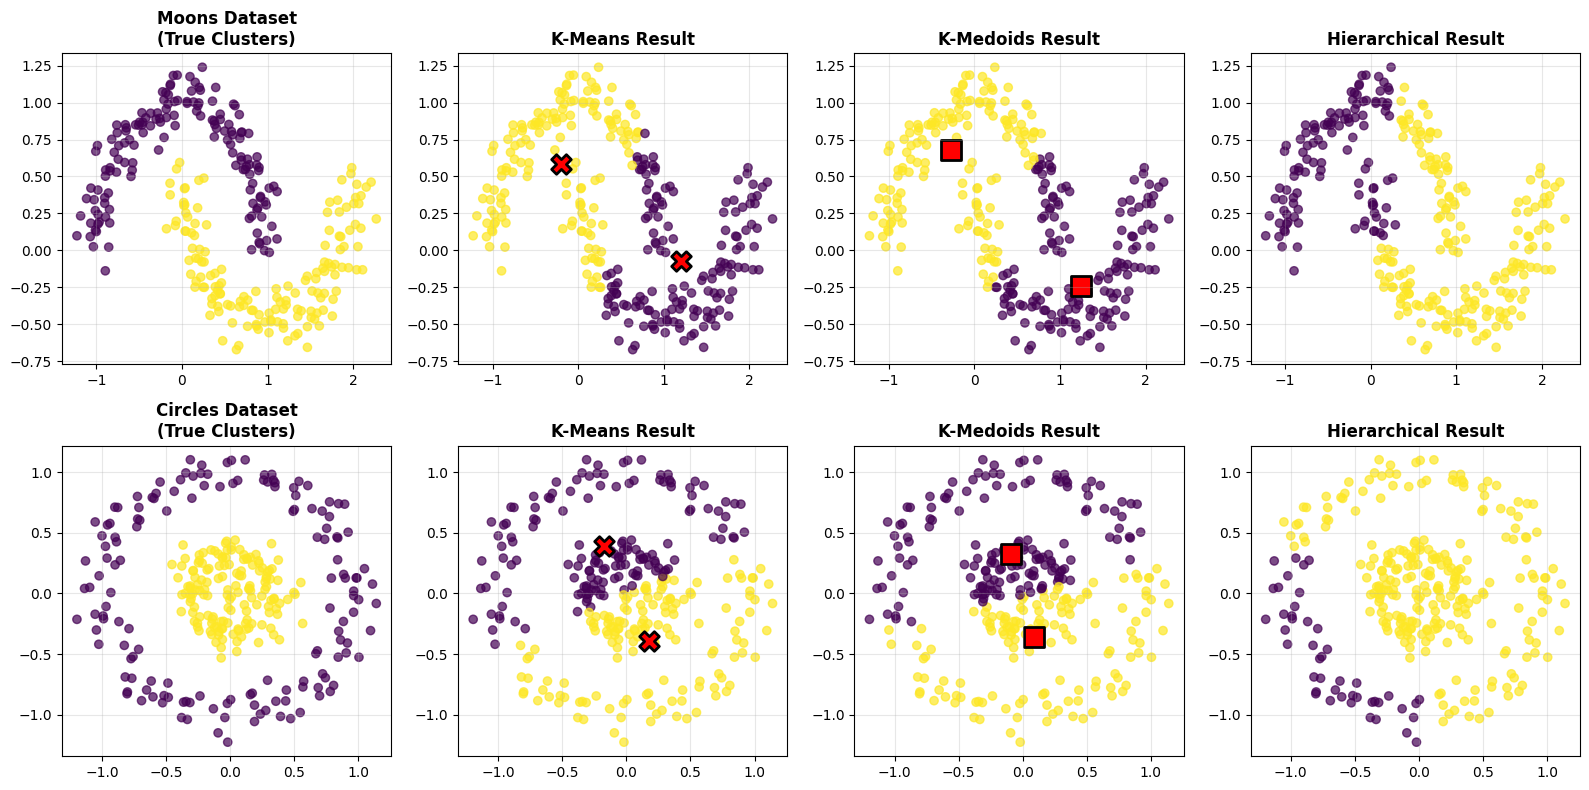

In [141]:
from sklearn.datasets import make_moons, make_circles

# Generate challenging datasets
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Dataset 1: Moons
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Dataset 2: Circles  
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=42)

datasets = [
    (X_moons, y_moons, "Moons"),
    (X_circles, y_circles, "Circles")
]

for row, (X, y_true, name) in enumerate(datasets):
    
    # Original data
    axes[row, 0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    axes[row, 0].set_title(f'{name} Dataset\n(True Clusters)', fontweight='bold')
    axes[row, 0].grid(True, alpha=0.3)
    
    # K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    axes[row, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
    axes[row, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                        c='red', marker='X', s=200, edgecolors='black', linewidth=2)
    axes[row, 1].set_title('K-Means Result', fontweight='bold')
    axes[row, 1].grid(True, alpha=0.3)
    
    # K-Medoids
    euclidean_dist = pairwise_distances(X, metric='euclidean')
    kmed = kmedoids.KMedoids(n_clusters=2, random_state=42)
    kmed.fit(euclidean_dist)
    medoids = X[kmed.medoid_indices_]
    axes[row, 2].scatter(X[:, 0], X[:, 1], c=kmed.labels_, cmap='viridis', alpha=0.7)
    axes[row, 2].scatter(medoids[:, 0], medoids[:, 1], 
                        c='red', marker='s', s=200, edgecolors='black', linewidth=2)
    axes[row, 2].set_title('K-Medoids Result', fontweight='bold')
    axes[row, 2].grid(True, alpha=0.3)
    
    # Hierarchical Clustering
    from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
    linkage_matrix = linkage(X, method='average')
    hierarchical_labels = fcluster(linkage_matrix, 2, criterion='maxclust') - 1
    axes[row, 3].scatter(X[:, 0], X[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.7)
    axes[row, 3].set_title('Hierarchical Result', fontweight='bold')
    axes[row, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Observations: When Shape Matters

The results show that all three traditional clustering algorithms struggle dramatically with non-spherical data:

### Moons Dataset:
- **K-Means & K-Medoids**: Split each crescent moon vertically instead of separating the two moons
- **Hierarchical**: Performs slightly better but still mixes points from both crescents

### Circles Dataset:  
- **K-Means & K-Medoids**: Create arbitrary radial splits rather than recognizing the concentric structure
- **Hierarchical**: Completely fails to distinguish inner from outer circle

### The Core Problem:
All these algorithms assume **spherical clusters** and use **Euclidean distance** as their primary metric. They fundamentally cannot detect clusters based on **density** or **connectivity**.

We need a different approach - one that can discover clusters of arbitrary shape by focusing on local density rather than global geometry. Let's explore a tool that can handle exactly these challenging scenarios!

---
<br><br>
# **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

K-Means, K-Medoids, and Hierarchical Clustering all assume clusters have similar sizes and spherical shapes. **DBSCAN** takes a fundamentally different approach by finding clusters based on local density rather than geometric assumptions.

### Key Advantages:
- **No need to specify number of clusters** - Algorithm discovers clusters automatically
- **Handles arbitrary cluster shapes** - Not limited to spherical clusters like K-means
- **Robust to outliers** - Identifies and labels noise points explicitly
- **Density-based** - Finds clusters of varying sizes and densities
- **Deterministic** - Same parameters always give same results

### Core Concepts:

**Dense Regions vs Sparse Regions:**
- **Core idea**: Clusters are dense regions separated by sparse regions
- **Noise points**: Isolated points in low-density areas
- **Arbitrary shapes**: Can find elongated, curved, or irregular clusters

### How DBSCAN Works:

**Step 1: Define Density**
- **ε (epsilon)**: Maximum distance to consider points as neighbors
- **MinPts**: Minimum number of points required to form a dense region

**Step 2: Classify Points**
- **Core points**: Have at least MinPts neighbors within ε distance
- **Border points**: Not core points but within ε of a core point
- **Noise points**: Neither core nor border points

**Step 3: Form Clusters**
- Start with any unvisited core point
- Add all density-reachable points to the same cluster
- Repeat until all core points are processed

**Step 4: Handle Remaining Points**
- Border points join the cluster of nearest core point
- Noise points remain unassigned (labeled as -1)

### The Parameter Challenge:
The biggest challenge with DBSCAN is choosing appropriate **ε** and **MinPts** parameters. We'll explore systematic approaches to parameter selection and see how DBSCAN finally succeeds where traditional methods failed!

Let's start by finding an appropriate **ε**.

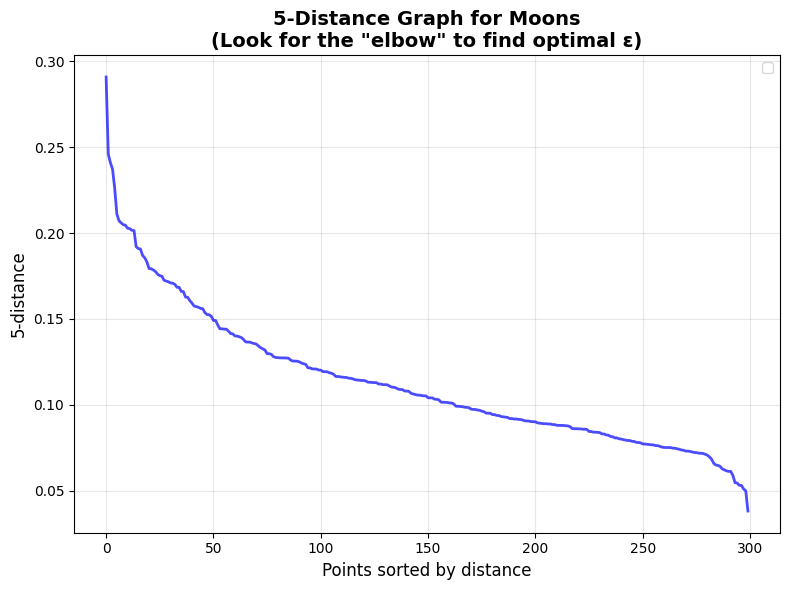

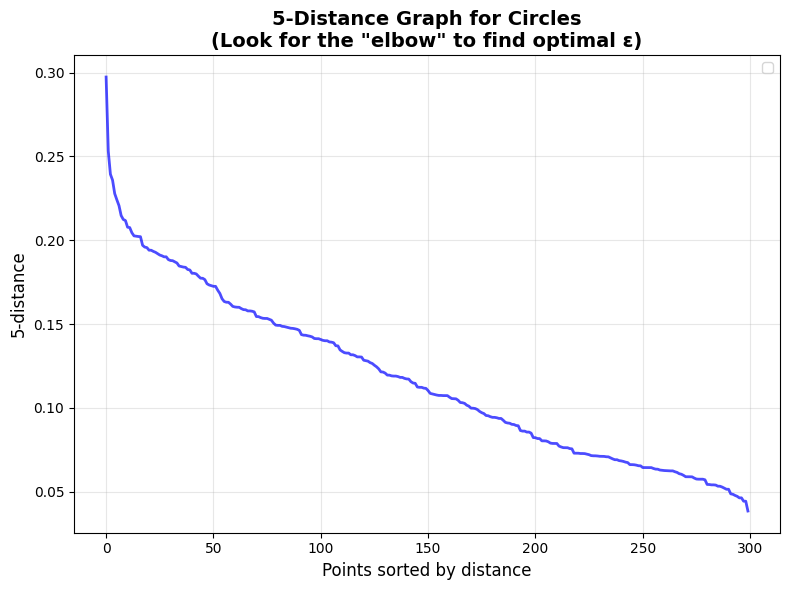

In [145]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def plot_k_distance_graph(X, k=4, dataset_name="Dataset"):
    """
    Plot k-distance graph to help determine optimal epsilon for DBSCAN
    
    Parameters:
    X: dataset
    k: k-th nearest neighbor (default=4, rule of thumb: k = minPts - 1)
    """
    
    # Calculate k-distance for each point
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Get k-th distance (last column) and sort in descending order
    k_distances = distances[:, k-1]
    k_distances = np.sort(k_distances)[::-1]
    
    # Plot k-distance graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2, alpha=0.7)
    plt.xlabel('Points sorted by distance', fontsize=12)
    plt.ylabel(f'{k}-distance', fontsize=12)
    plt.title(f'{k}-Distance Graph for {dataset_name}\n(Look for the "elbow" to find optimal ε)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return k_distances

# Moons dataset
k_dist_moons = plot_k_distance_graph(X_moons, k=5, dataset_name="Moons")

# Circles dataset  
k_dist_circles = plot_k_distance_graph(X_circles, k=5, dataset_name="Circles")

### Understanding the K-Distance Graph (TODO: Maybe shorten text)

The **k-distance graph** is a crucial tool for selecting the optimal ε parameter in DBSCAN. Here's how to interpret it:

#### What the Graph Shows:
- **X-axis**: All data points sorted by their distance to the k-th nearest neighbor (k=5 here)
- **Y-axis**: The actual distance to that k-th nearest neighbor
- **Curve shape**: Shows the distribution of local densities in your dataset

#### How to Use It:
- **Look for the "elbow" or "knee"**: The point where the curve changes from gradual to steep
- **Reality check**: In our plots, **no clear elbow is visible** - the curves show gradual transitions
- **This is common**: Real datasets often don't have obvious elbows, making parameter selection challenging

#### Why This Works (In Theory):
- **Dense regions** (right side): Points have close neighbors → small k-distances
- **Sparse regions** (left side): Points are isolated → large k-distances  
- **The elbow**: Should separate dense cluster cores from sparse noise/boundaries

#### The Parameter Selection Challenge:
- **No clear elbow**: Both datasets show smooth, gradual curves without sharp transitions
- **Trial and error needed**: Must test different ε values and evaluate clustering quality
- **This is DBSCAN's main limitation**: Parameter selection often requires experimentation

#### What Different ε Values Mean:
- **Too small ε** (< 0.15): Only very dense cores become clusters → many noise points
- **Reasonable testing range** (0.15-0.22): Based on our k-distance analysis, this seems like a sensible range to start testing for both datasets
- **Candidate range** (≈ 0.17-0.22): Focus on these values from the percentile suggestions
- **Too large ε** (> 0.22): Sparse regions get merged → few large clusters

**Bottom line**: The k-distance graph provides guidance, but we still need to test multiple ε values to find the best clustering results.



### Finding Suitable MinPts

While the k-distance graph helps with ε selection, choosing **MinPts** also requires consideration:

#### Common Rules of Thumb:

1. **Dimensionality-based**: MinPts ≥ D + 1, where D = number of features
   - For our 2D datasets: MinPts ≥ 3
   - **Limitation**: This rule can be too conservative for high-dimensional data

2. **General recommendation**: MinPts = 4 or 5 for most 2D problems
   - **Why**: Provides good balance between noise detection and cluster formation
   - **Our choice**: We used MinPts = 5 (hence k=4 in the k-distance graph)

3. **Domain-specific**: Consider the minimum meaningful cluster size
   - **Question**: What's the smallest group that makes sense in your context?
   - **Example**: For customer segmentation, maybe 10+ customers per segment

#### Testing Strategy:
- **Start with MinPts = 4-5** for 2D data
- **Lower values (2-3)**: More sensitive to noise, might create many small clusters
- **Higher values (6-10)**: More robust to noise, but might merge small legitimate clusters
- **Systematic approach**: Test combinations of (ε, MinPts) and evaluate results

#### The Reality:
**No perfect formula exists** - both ε and MinPts often require experimentation based on:
- Dataset characteristics
- Domain knowledge  
- Desired cluster granularity
- Tolerance for noise points

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle, islice
from sklearn import cluster

def plot_dbscan_grid(dataset, eps_values, min_samples_values):
    
    fig = plt.figure(figsize=(16, 20))
    plt.subplots_adjust(left=.02, right=.98, bottom=0.001, top=.96, wspace=.05,
                        hspace=0.25)


    plot_num = 1

    for i, min_samples in enumerate(min_samples_values):
        for j, eps in enumerate(eps_values):
            ax = fig.add_subplot( len(min_samples_values) , len(eps_values), plot_num)

            dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
            y_pred_2 = dbscan.fit_predict(dataset)

            colors = np.array(list(islice(cycle(['#df8efd', '#78c465', '#ff8e34',
                                                 '#f65e97', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred_2) + 1))))
            colors = np.append(colors, '#BECBD6')


            for point in dataset:
                circle1 = plt.Circle(point, eps, color='#666666', fill=False, zorder=0, alpha=0.3)
                ax.add_artist(circle1)

            ax.text(0, -0.03, 'Epsilon: {} \nMin_samples: {}'.format(eps, min_samples), transform=ax.transAxes, fontsize=16, va='top')
            ax.scatter(dataset[:, 0], dataset[:, 1], s=50, color=colors[y_pred_2], zorder=10, edgecolor='black', lw=0.5)


            plt.xticks(())
            plt.yticks(())

            # Calculate the limits for the plot
            x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
            y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)

            #plt.xlim(-14, 5)
            #plt.ylim(-12, 7)

            plot_num = plot_num + 1

    plt.show()

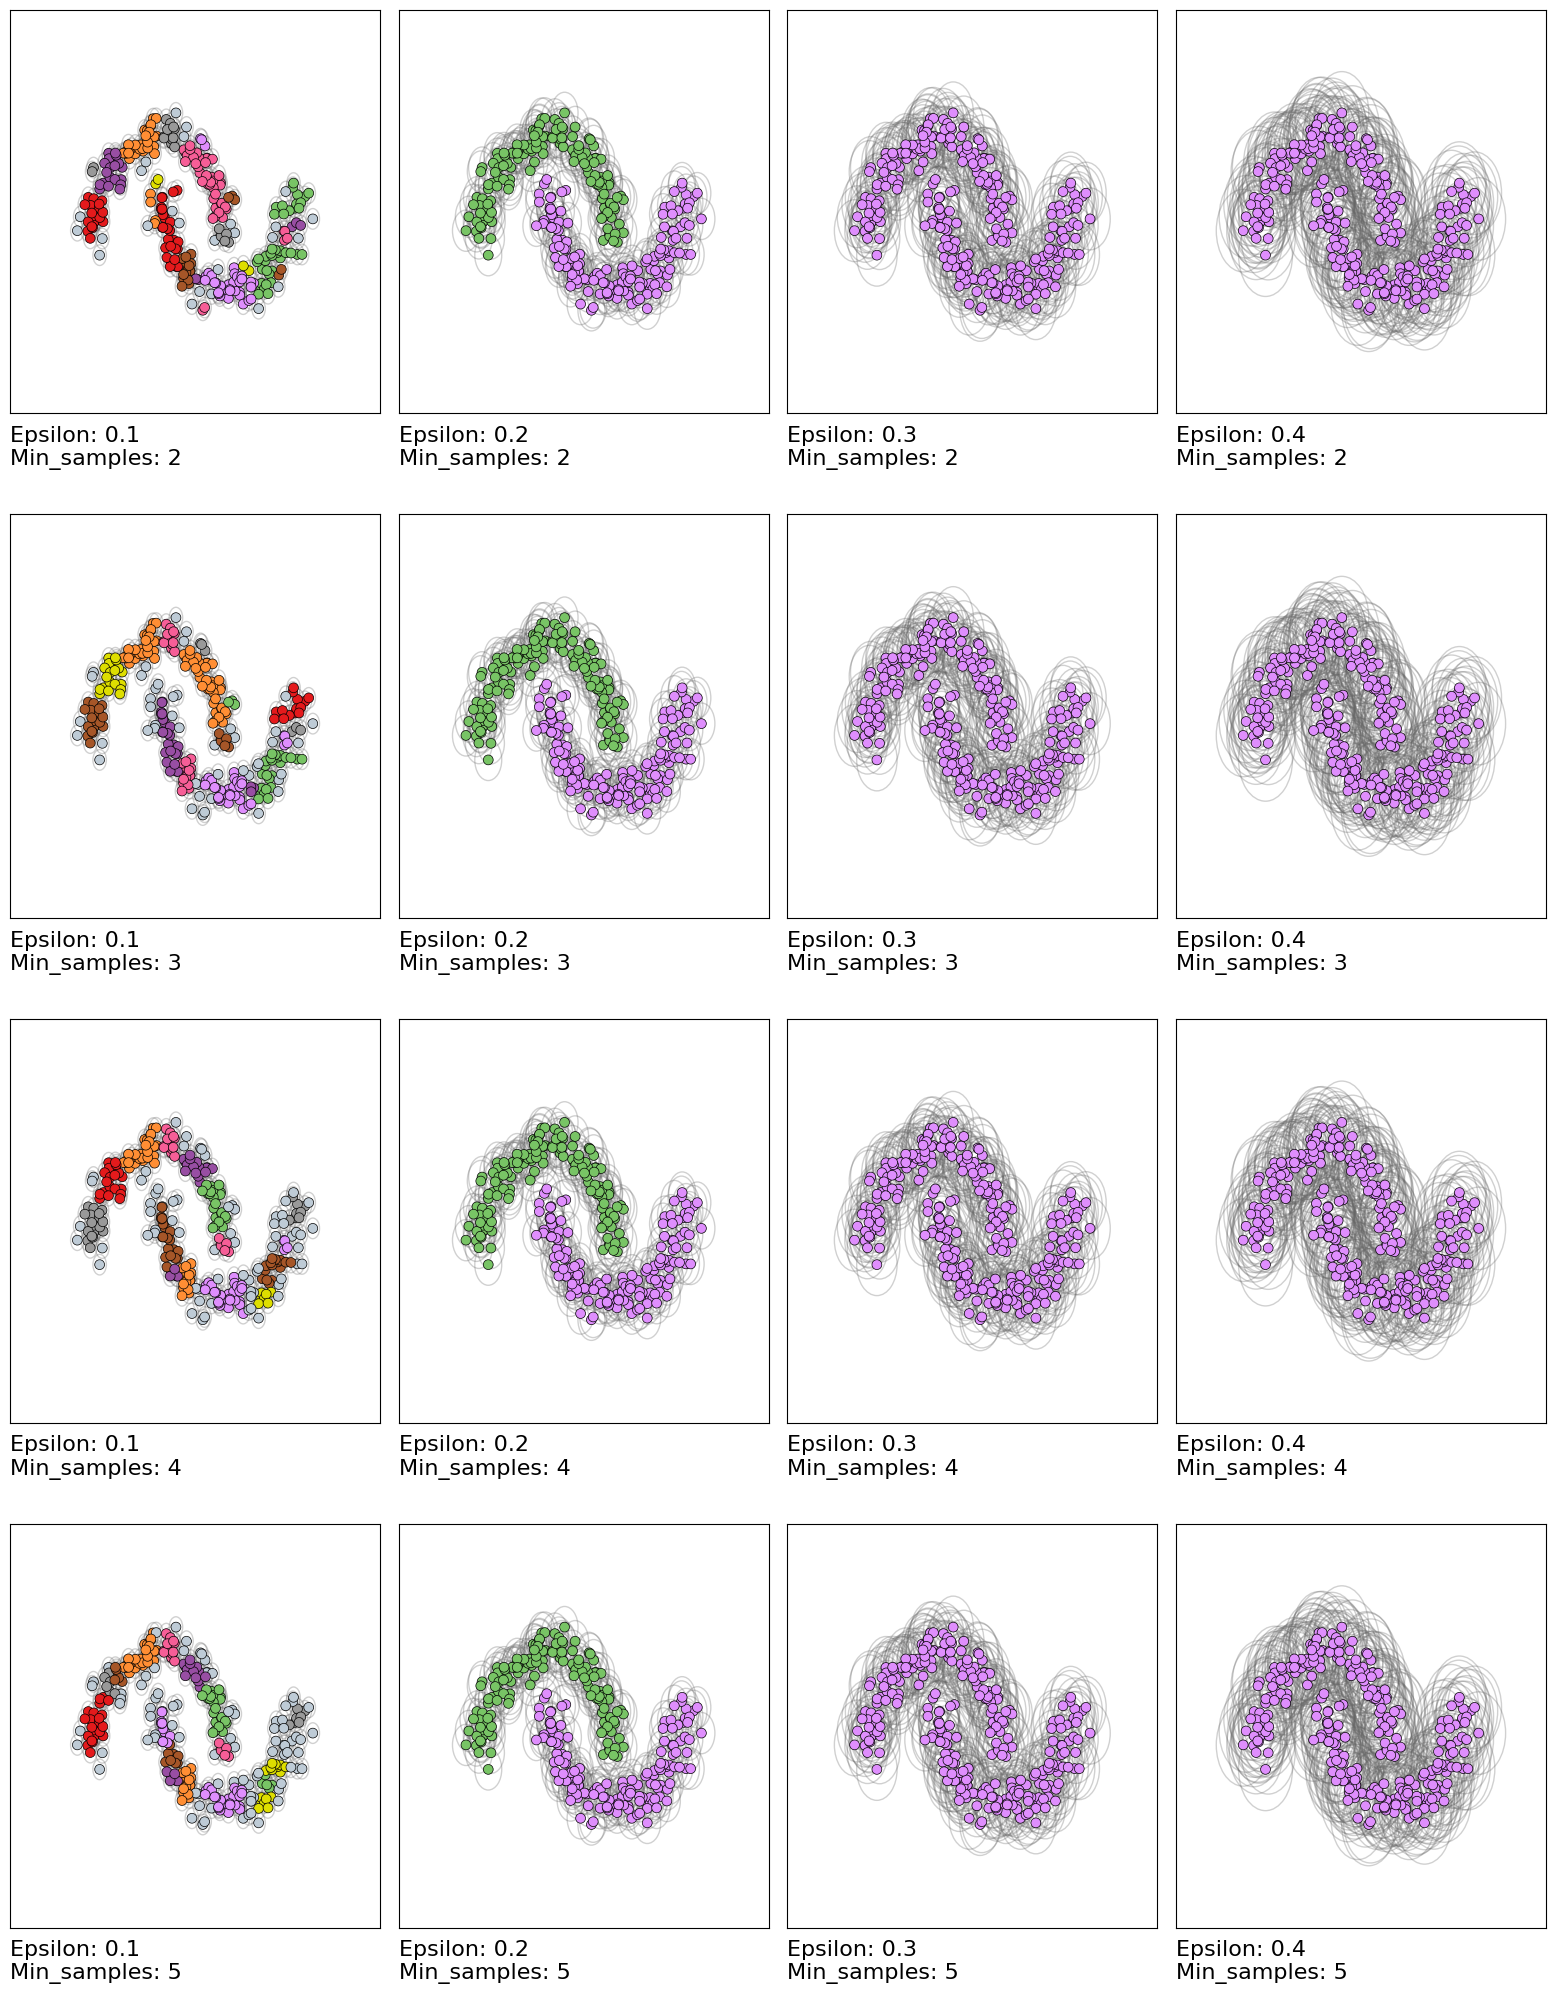

In [150]:
plot_dbscan_grid(X_moons, eps_values=[0.1, 0.2, 0.3, 0.4], min_samples_values=[2, 3, 4, 5])

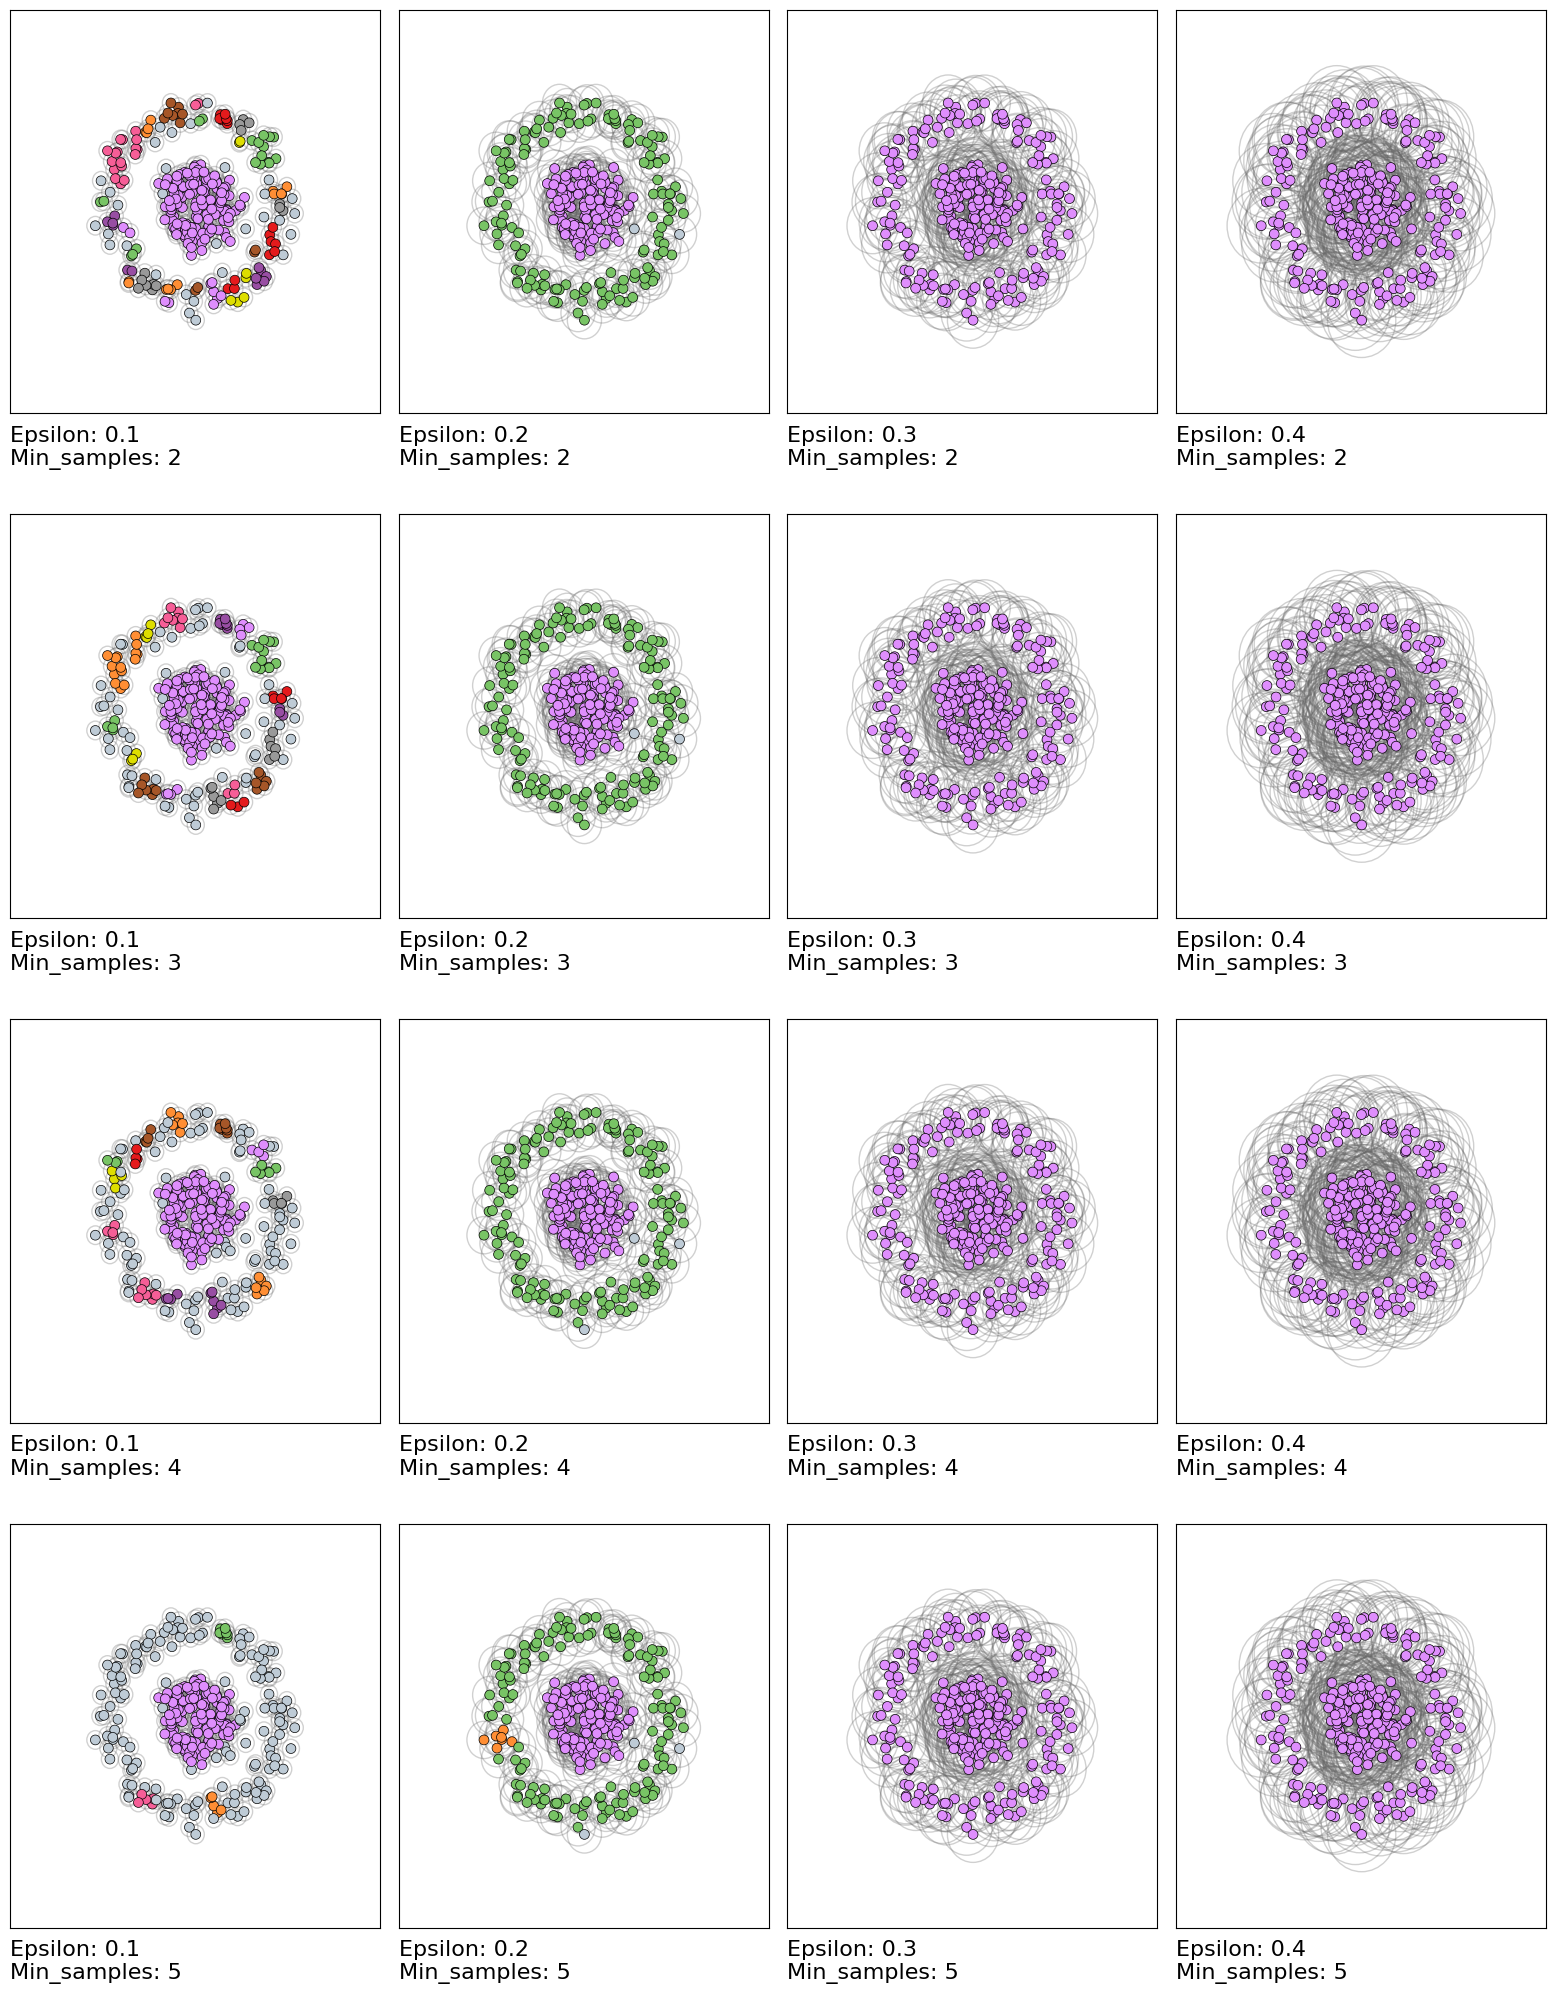

In [151]:
plot_dbscan_grid(X_circles, eps_values=[0.1, 0.2, 0.3, 0.4], min_samples_values=[2, 3, 4, 5])

### DBSCAN Parameter Effects

**ε (epsilon)**: Maximum distance between points to be considered neighbors
**MinPts**: Minimum number of neighbors required for a point to be a "core point"

### Key Observations from Parameter Grid:

**ε Effect (horizontal comparison):**
- **Small ε (0.1)**: Very strict neighborhoods → few clusters, lots of noise
- **Medium ε (0.3)**: Too many tiny clusters (over-segmentation)
- **Larger ε (0.5-1.0)**: Balanced clustering with reasonable cluster sizes

**MinPts Effect (vertical comparison):**
- **Low MinPts (2)**: Less strict density requirement → fewer noise points
- **High MinPts (5)**: Stricter density requirement → more noise points

**Best Results:**
- **ε=0.5, MinPts=5**: Clean separation into 3 clusters (matches wine varieties!)
- **ε=1.0, MinPts=4**: Also good with 3 well-separated clusters
- **Sweet spot**: ε around 0.5-1.0 captures the natural wine variety structure

The k-distance graph suggestion (ε≈0.29) was close but slightly conservative - real-world parameter tuning often requires experimentation around the suggested value.

---
<br><br>
# **Clustering Methods Overview**

### K-Means & K-Medoids Clustering
- **Advantages:**
  - Fast and scalable for large datasets (K-Means faster)
  - Simple to implement and understand
  - Works well with spherical, similar-sized clusters
  - **K-Medoids**: More robust to outliers, uses actual data points as centers

- **Disadvantages:**
  - Must specify k beforehand
  - Assumes spherical clusters
  - **K-Means**: Sensitive to outliers and initialization
  - **K-Medoids**: Slower than K-Means, still sensitive to initialization

### Hierarchical Clustering
- **Advantages:**
  - No need to specify number of clusters
  - Provides complete hierarchy (dendrogram)
  - Deterministic results

- **Disadvantages:**
  - Computationally expensive O(n³)
  - Poor scalability for large datasets
  - Sensitive to noise and outliers

### DBSCAN
- **Advantages:**
  - Automatically finds number of clusters
  - Handles arbitrary shapes and noise/outliers
  - No cluster shape assumptions

- **Disadvantages:**
  - Challenging parameter tuning (ε, MinPts)
  - Struggles with varying densities
  - Requires experimentation to get right

### Quick Selection Guide

| Use Case | Best Method |
|----------|-------------|
| **Large datasets, spherical clusters** | K-Means |
| **Medium datasets, robust to outliers** | K-Medoids |
| **Small datasets, need hierarchy** | Hierarchical |
| **Complex shapes, noisy data** | DBSCAN |

If your dataset allows it feel free to use differetn methods and compare their outputs! Let's transfer our knowledge to a medical dataset next!

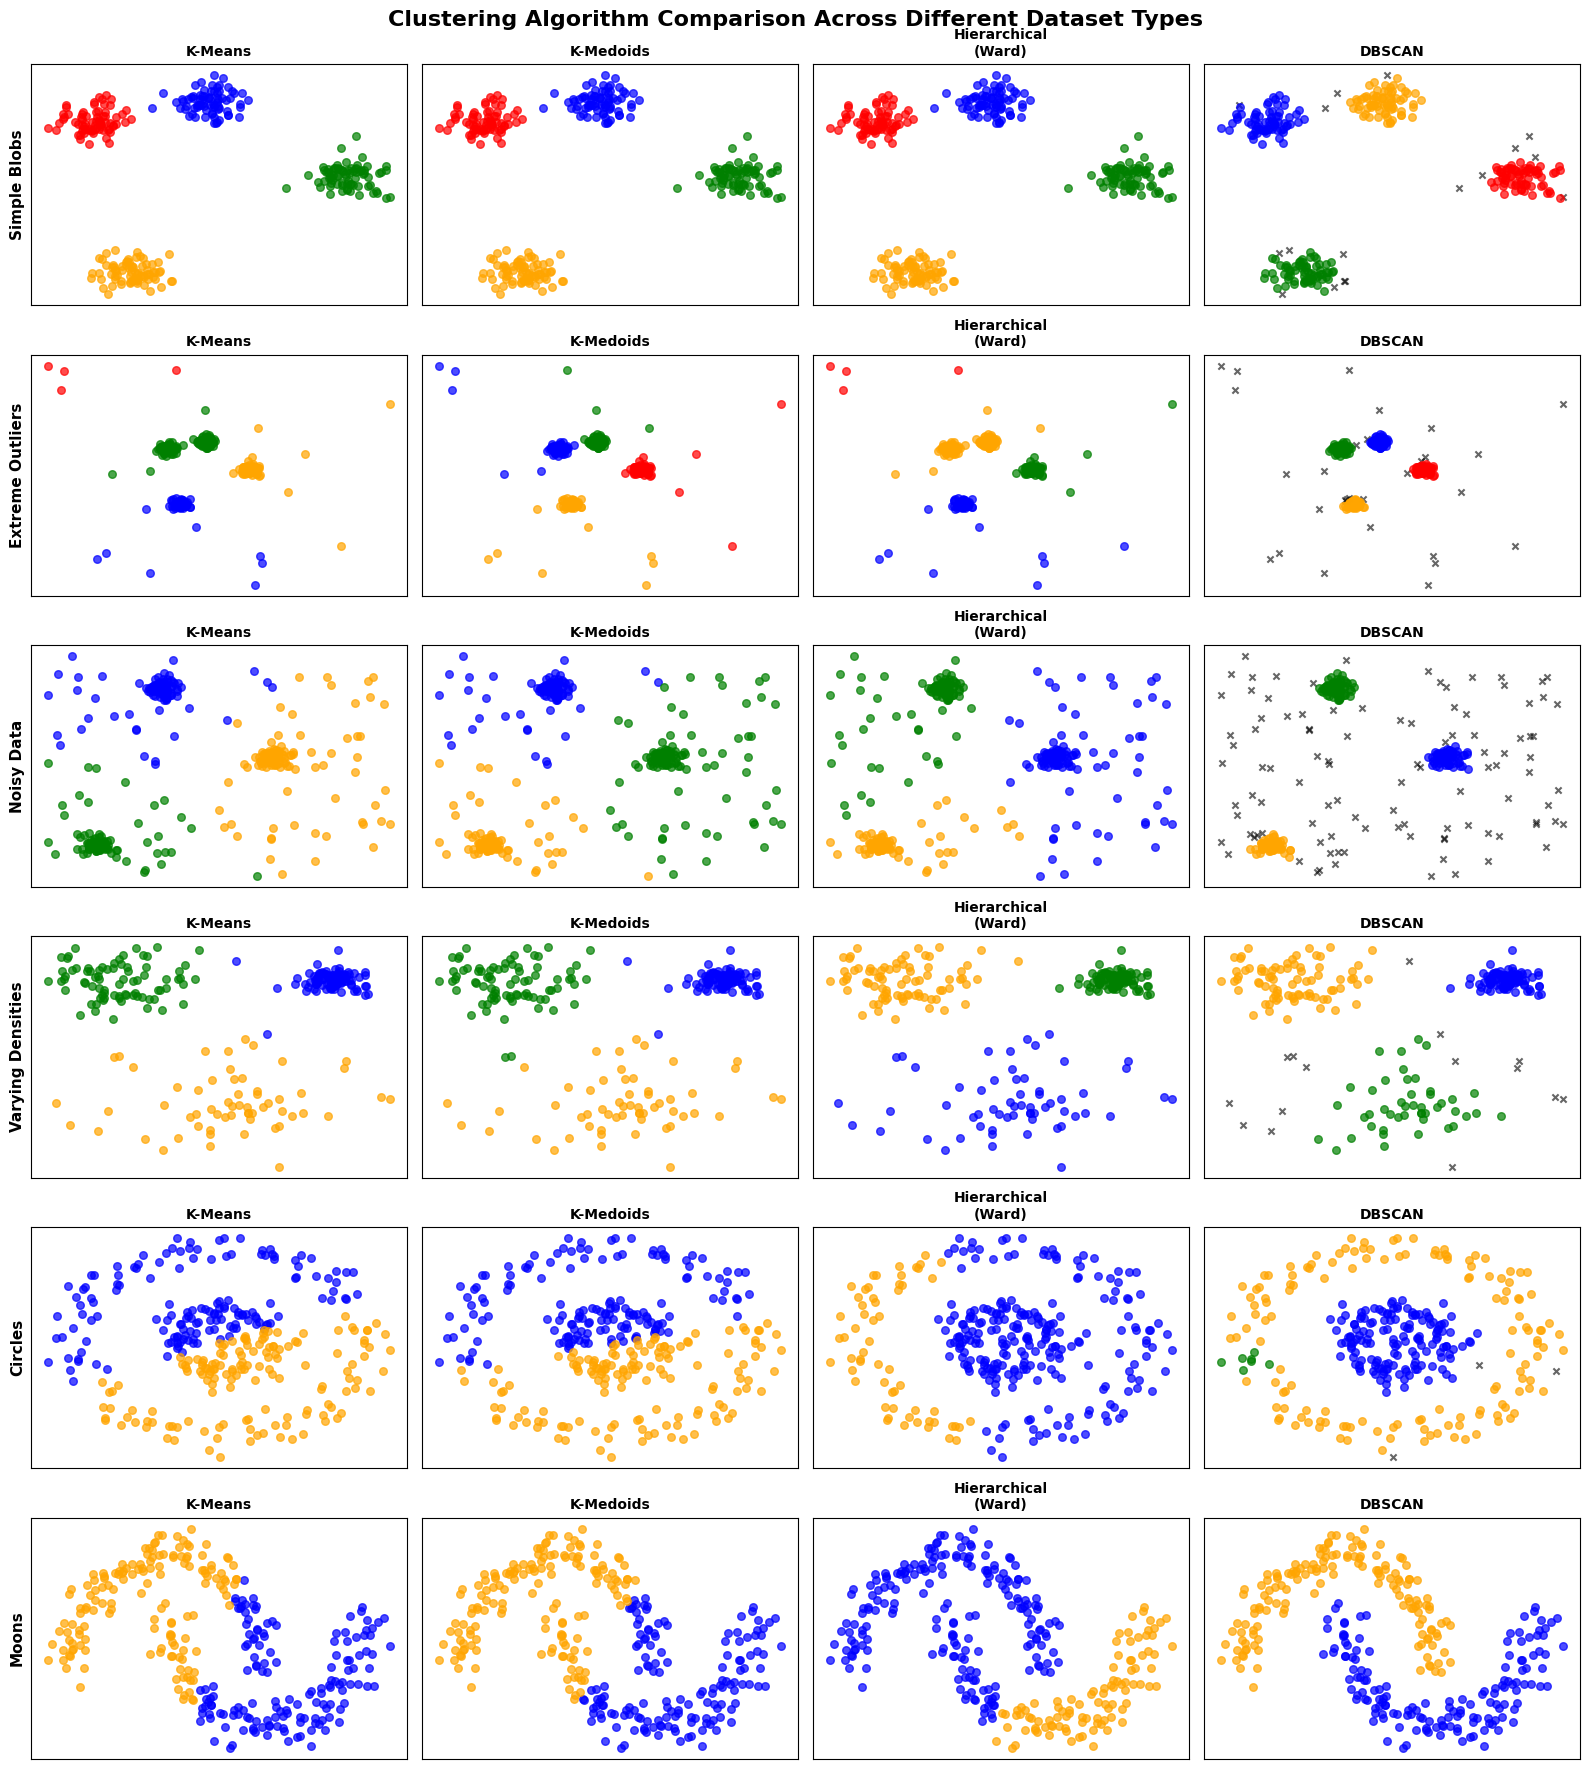

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
import kmedoids
from scipy.cluster.hierarchy import linkage, fcluster

# Set random seed for reproducibility
np.random.seed(42)

def create_datasets():
    """Create various challenging datasets"""
    datasets = {}
    
    # 1. Simple blobs (baseline)
    X_blobs, _ = make_blobs(n_samples=300, centers=4, n_features=2, 
                           random_state=42, cluster_std=1.0)
    datasets['Simple Blobs'] = X_blobs
    
    # 2. Blobs with extreme outliers
    X_blobs_out, _ = make_blobs(n_samples=280, centers=4, n_features=2, 
                               random_state=42, cluster_std=0.8)
    # Add extreme outliers
    outliers = np.random.uniform(-30, 30, (20, 2))
    X_outliers = np.vstack([X_blobs_out, outliers])
    datasets['Extreme Outliers'] = X_outliers
    
    # 3. Very noisy data
    X_blobs_noisy, _ = make_blobs(n_samples=200, centers=3, n_features=2, 
                                 random_state=42, cluster_std=0.6)
    # Add lots of noise
    noise = np.random.uniform(X_blobs_noisy.min()-2, X_blobs_noisy.max()+2, (100, 2))
    X_noisy = np.vstack([X_blobs_noisy, noise])
    datasets['Noisy Data'] = X_noisy
    
    # 4. Varying densities
    # Dense cluster
    dense_cluster = np.random.multivariate_normal([2, 2], [[0.1, 0], [0, 0.1]], 100)
    # Medium density cluster  
    medium_cluster = np.random.multivariate_normal([-2, 2], [[0.5, 0], [0, 0.5]], 80)
    # Sparse cluster
    sparse_cluster = np.random.multivariate_normal([0, -3], [[1.5, 0], [0, 1.5]], 60)
    X_varying = np.vstack([dense_cluster, medium_cluster, sparse_cluster])
    datasets['Varying Densities'] = X_varying
    
    # 5. Circles
    X_circles, _ = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=42)
    datasets['Circles'] = X_circles
    
    # 6. Moons
    X_moons, _ = make_moons(n_samples=300, noise=0.1, random_state=42)
    datasets['Moons'] = X_moons
    
    return datasets

def apply_clustering_algorithms(X, dataset_name):
    """Apply all clustering algorithms to dataset"""
    results = {}
    
    # Determine number of clusters (except for DBSCAN)
    if dataset_name in ['Circles', 'Moons']:
        n_clusters = 2
    elif dataset_name in ['Simple Blobs', 'Extreme Outliers']:
        n_clusters = 4
    elif dataset_name == 'Noisy Data':
        n_clusters = 3
    else:
        n_clusters = 3
    
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    results['K-Means'] = kmeans.fit_predict(X)
    
    # K-Medoids
    kmed = kmedoids.KMedoids(n_clusters=n_clusters, random_state=42)
    euclidean_dist = pairwise_distances(X, metric='euclidean')
    kmed.fit(euclidean_dist)
    results['K-Medoids'] = kmed.labels_
    
    # Hierarchical Clustering (Ward)
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    results['Hierarchical\n(Ward)'] = ward.fit_predict(X)
    
    # DBSCAN - parameter selection based on dataset
    eps_params = {
        'Simple Blobs': 0.8,
        'Extreme Outliers': 0.8,
        'Noisy Data': 0.6,
        'Varying Densities': 0.8,
        'Circles': 0.2,
        'Moons': 0.2
    }
    
    dbscan = DBSCAN(eps=eps_params[dataset_name], min_samples=5)
    results['DBSCAN'] = dbscan.fit_predict(X)
    
    return results

def plot_clustering_comparison():
    """Create the comprehensive clustering comparison plot"""
    datasets = create_datasets()
    algorithms = ['K-Means', 'K-Medoids', 'Hierarchical\n(Ward)', 'DBSCAN']
    
    # Create the plot
    fig, axes = plt.subplots(len(datasets), len(algorithms), 
                            figsize=(16, 18))
    
    # Color maps
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
    
    for row, (dataset_name, X) in enumerate(datasets.items()):
        # Apply all clustering algorithms
        results = apply_clustering_algorithms(X, dataset_name)
        
        for col, algorithm in enumerate(algorithms):
            ax = axes[row, col]
            labels = results[algorithm]
            
            # Handle DBSCAN noise points (labeled as -1)
            unique_labels = np.unique(labels)
            for i, label in enumerate(unique_labels):
                if label == -1:  # Noise points in DBSCAN
                    mask = labels == label
                    ax.scatter(X[mask, 0], X[mask, 1], c='black', 
                              marker='x', s=20, alpha=0.6, label='Noise')
                else:
                    mask = labels == label
                    color_idx = label % len(colors)
                    ax.scatter(X[mask, 0], X[mask, 1], c=colors[color_idx], 
                              s=30, alpha=0.7)
            
            # Formatting
            ax.set_title(f'{algorithm}', fontweight='bold', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add dataset name on the left
            if col == 0:
                ax.set_ylabel(dataset_name, fontweight='bold', fontsize=11, rotation=90)
    
    plt.tight_layout()
    plt.suptitle('Clustering Algorithm Comparison Across Different Dataset Types', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Create the comparison plot
plot_clustering_comparison()

---
<br><br>
# Maybe show wine dataset here, that K-Means and hierarchical have troubles on high-dimensional data, we can do PCA or U-Map to reduce dimensionality and cluster on reduced data

---
<br><br>
# **Applying Clustering to Medical Data**

Now that we've mastered clustering techniques on wine data, let's explore how these same methods can reveal patterns in medical datasets. Understanding patient groups can help identify disease subtypes, risk profiles, and treatment pathways.

## Gene Expression Cancer Dataset Introduction

**RNA-Seq (RNA Sequencing)** is a powerful technique that measures gene expression levels across thousands of genes simultaneously. In cancer research, this data helps us understand:

- **Molecular signatures**: Different cancer types have distinct gene expression patterns
- **Treatment targets**: Genes that are over/under-expressed in specific cancers
- **Patient stratification**: Grouping patients based on molecular profiles for personalized treatment

We will use this dataset to visualize the clustering algorithms, however we will encounter some challenges.

### The Clustering Challenge:
- **High dimensionality**: RNA-Seq datasets typically have 20,000+ genes (features)
- **Curse of dimensionality**: Traditional clustering algorithms struggle in high-dimensional spaces
- **Noise and redundancy**: Many genes are irrelevant or correlated
- **Small sample size**: Often hundreds of patients vs. thousands of genes

We try to use clustering to identify distinct cancer types or subtypes based on gene expression profiles.

Dataset Overview:
   - Samples (patients): 801
   - Features (genes): 20531
   - Data size: 801 × 20531


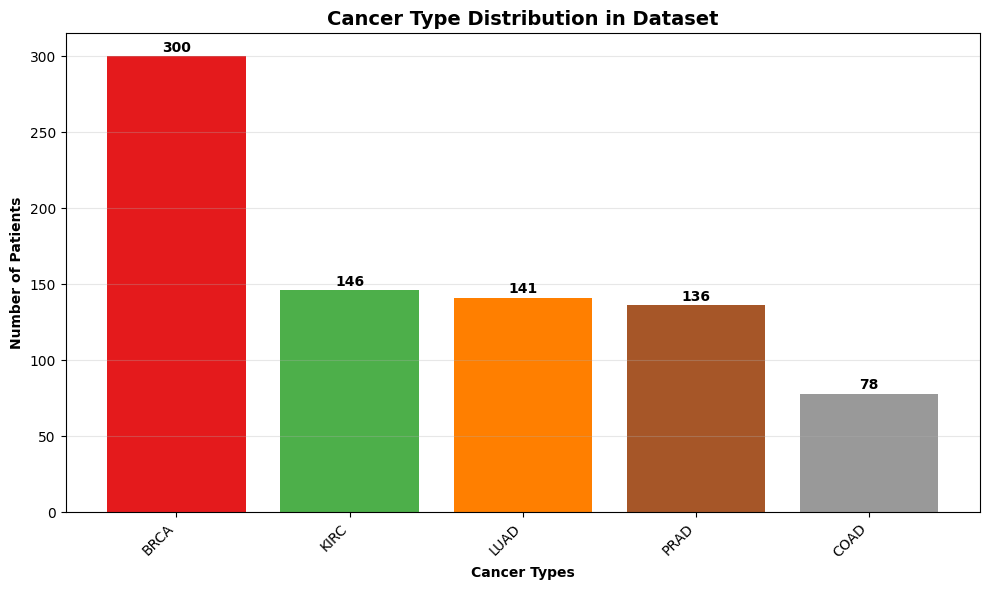

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns

# Load gene expression data and labels
gene_data = pd.read_csv('gene_data.csv', index_col=0)
gene_labels = pd.read_csv('gene_labels.csv', index_col=0)

# Basic dataset information
print(f"Dataset Overview:")
print(f"   - Samples (patients): {gene_data.shape[0]}")
print(f"   - Features (genes): {gene_data.shape[1]}")
print(f"   - Data size: {gene_data.shape[0]} × {gene_data.shape[1]}")

# Create bar plot of cancer type distribution
label_counts = gene_labels.iloc[:, 0].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(label_counts)), label_counts.values, 
               color=plt.cm.Set1(np.linspace(0, 1, len(label_counts))))

plt.title('Cancer Type Distribution in Dataset', fontweight='bold', fontsize=14)
plt.xlabel('Cancer Types', fontweight='bold')
plt.ylabel('Number of Patients', fontweight='bold')
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, (cancer_type, count) in enumerate(label_counts.items()):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

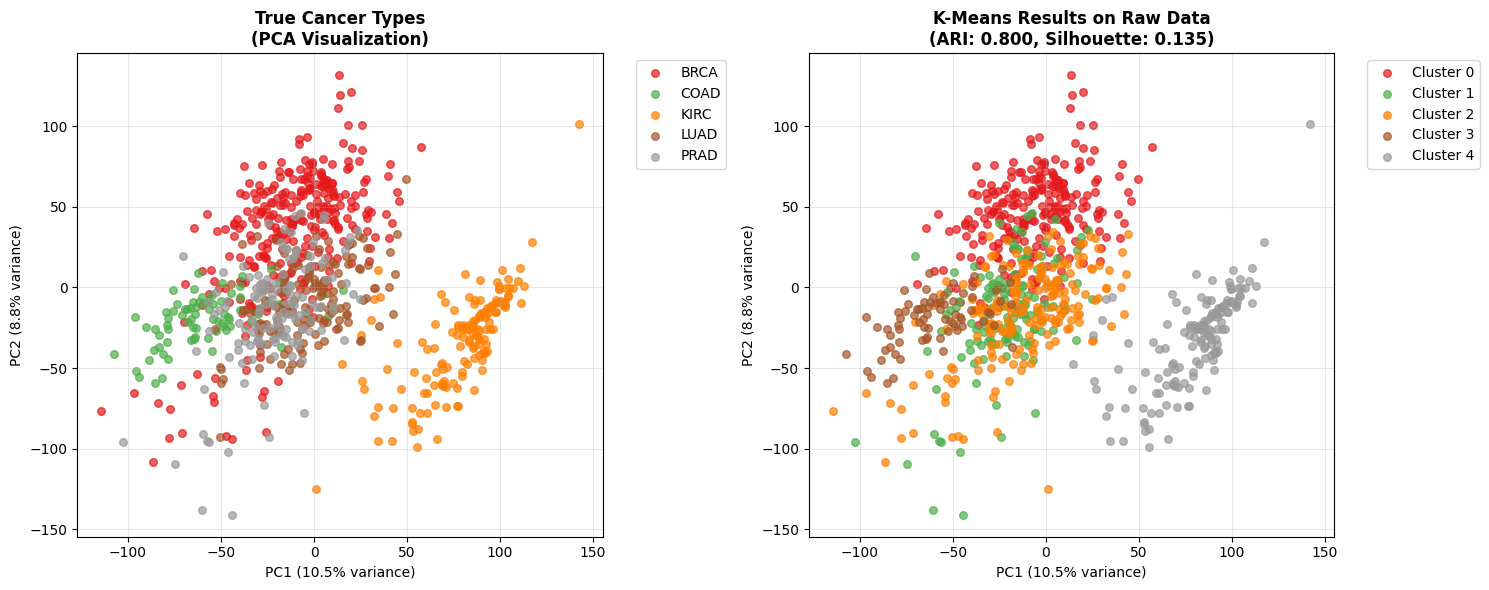

In [42]:
# Apply K-Means clustering on raw high-dimensional data

# Prepare the data
X_raw = gene_data.values
y_true = gene_labels.iloc[:, 0].values

# Standardize the data (important for gene expression)
scaler = StandardScaler()
X_raw_scaled = scaler.fit_transform(X_raw)

# Determine number of clusters from true labels
n_clusters = len(np.unique(y_true))

# Apply K-Means on raw data
kmeans_raw = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_raw = kmeans_raw.fit_predict(X_raw_scaled)

# Evaluate clustering performance
ari_raw = adjusted_rand_score(y_true, labels_raw)
sil_raw = silhouette_score(X_raw_scaled, labels_raw)

#print(f"Silhouette Score: {sil_raw:.3f}")

# Apply PCA for visualization (2 components)
pca_viz = PCA(n_components=2, random_state=42)
X_pca_viz = pca_viz.fit_transform(X_raw_scaled)

# Create visualization using PCA-reduced space
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: True cancer types in PCA space
unique_true = np.unique(y_true)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_true)))

for i, cancer_type in enumerate(unique_true):
    mask = y_true == cancer_type
    axes[0].scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                   c=[colors[i]], label=cancer_type, alpha=0.7, s=30)

axes[0].set_title('True Cancer Types\n(PCA Visualization)', 
                 fontweight='bold', fontsize=12)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: K-Means results on raw data (visualized in PCA space)
unique_pred = np.unique(labels_raw)
colors_pred = plt.cm.Set1(np.linspace(0, 1, len(unique_pred)))

for i, cluster in enumerate(unique_pred):
    mask = labels_raw == cluster
    axes[1].scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                   c=[colors_pred[i]], label=f'Cluster {cluster}', alpha=0.7, s=30)

axes[1].set_title(f'K-Means Results on Raw Data\n(ARI: {ari_raw:.3f}, Silhouette: {sil_raw:.3f})', 
                 fontweight='bold', fontsize=12)
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Reduced from 20531 genes to 10 principal components
Total variance explained: 46.6%
Silhouette Score: 0.333


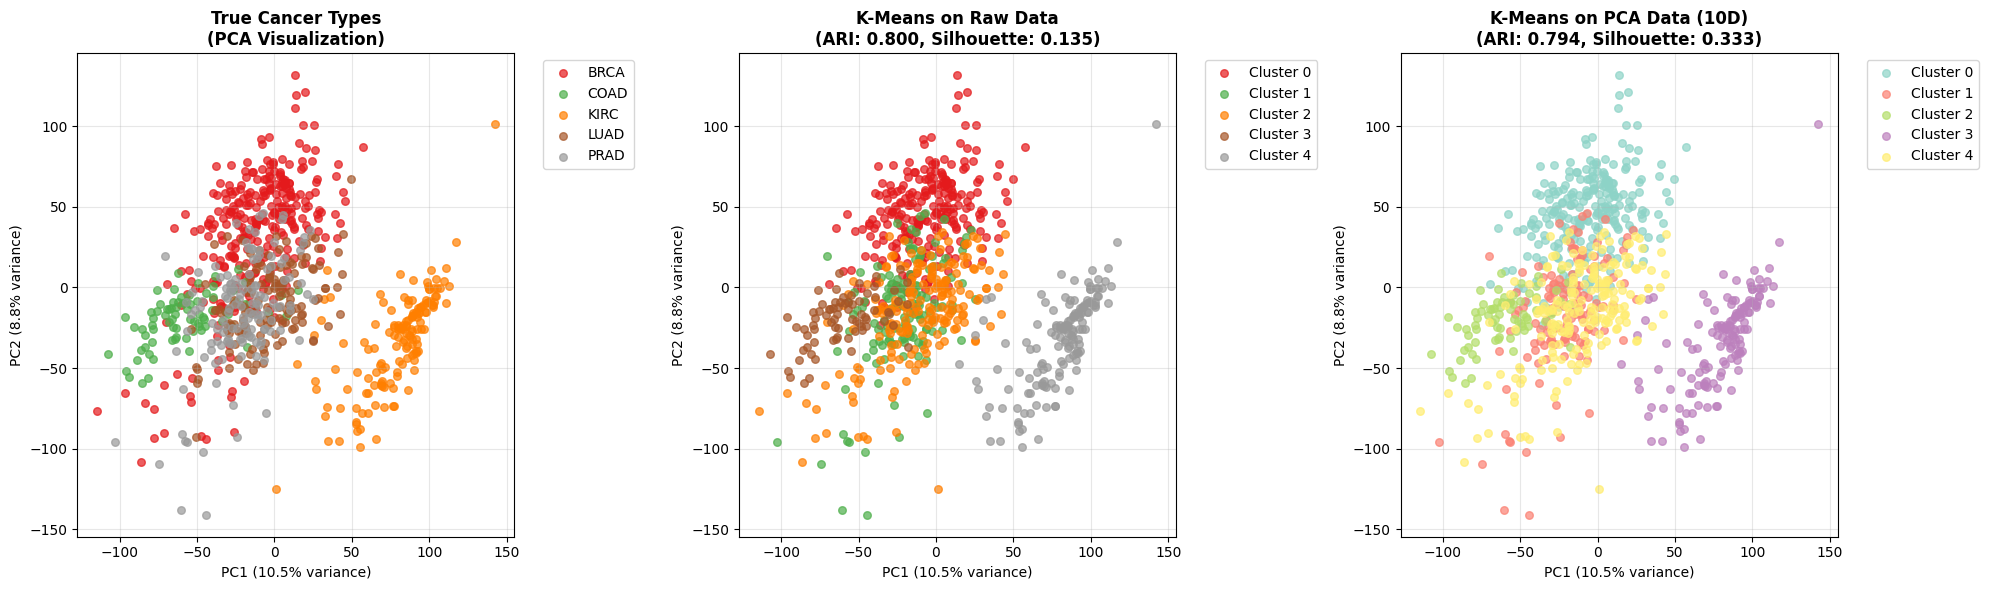

In [43]:
# Apply PCA for dimensionality reduction and then cluster

# Apply PCA to reduce to 10 components
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_raw_scaled)

print(f"Reduced from {X_raw_scaled.shape[1]} genes to {X_pca.shape[1]} principal components")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Apply K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

# Evaluate clustering performance
ari_pca = adjusted_rand_score(y_true, labels_pca)
sil_pca = silhouette_score(X_pca, labels_pca)

print(f"Silhouette Score: {sil_pca:.3f}")

# For visualization, use the same 2-component PCA as before
X_pca_viz = pca_viz.transform(X_raw_scaled)

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: True cancer types in PCA space
for i, cancer_type in enumerate(unique_true):
    mask = y_true == cancer_type
    axes[0].scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                   c=[colors[i]], label=cancer_type, alpha=0.7, s=30)

axes[0].set_title('True Cancer Types\n(PCA Visualization)', 
                 fontweight='bold', fontsize=12)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: K-Means on raw data (visualized in PCA space)
for i, cluster in enumerate(unique_pred):
    mask = labels_raw == cluster
    axes[1].scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                   c=[colors_pred[i]], label=f'Cluster {cluster}', alpha=0.7, s=30)

axes[1].set_title(f'K-Means on Raw Data\n(ARI: {ari_raw:.3f}, Silhouette: {sil_raw:.3f})', 
                 fontweight='bold', fontsize=12)
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

# Plot 3: K-Means on PCA-reduced data (visualized in PCA space)
unique_pred_pca = np.unique(labels_pca)
colors_pred_pca = plt.cm.Set3(np.linspace(0, 1, len(unique_pred_pca)))

for i, cluster in enumerate(unique_pred_pca):
    mask = labels_pca == cluster
    axes[2].scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                   c=[colors_pred_pca[i]], label=f'Cluster {cluster}', alpha=0.7, s=30)

axes[2].set_title(f'K-Means on PCA Data (10D)\n(ARI: {ari_pca:.3f}, Silhouette: {sil_pca:.3f})', 
                 fontweight='bold', fontsize=12)
axes[2].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
axes[2].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

   K-Means        : ARI = 0.794, Silhouette = 0.333
   K-Medoids      : ARI = 0.921, Silhouette = 0.329
   Hierarchical (Ward): ARI = 0.757, Silhouette = 0.327
   DBSCAN         : ARI = 0.823, Silhouette = 0.290


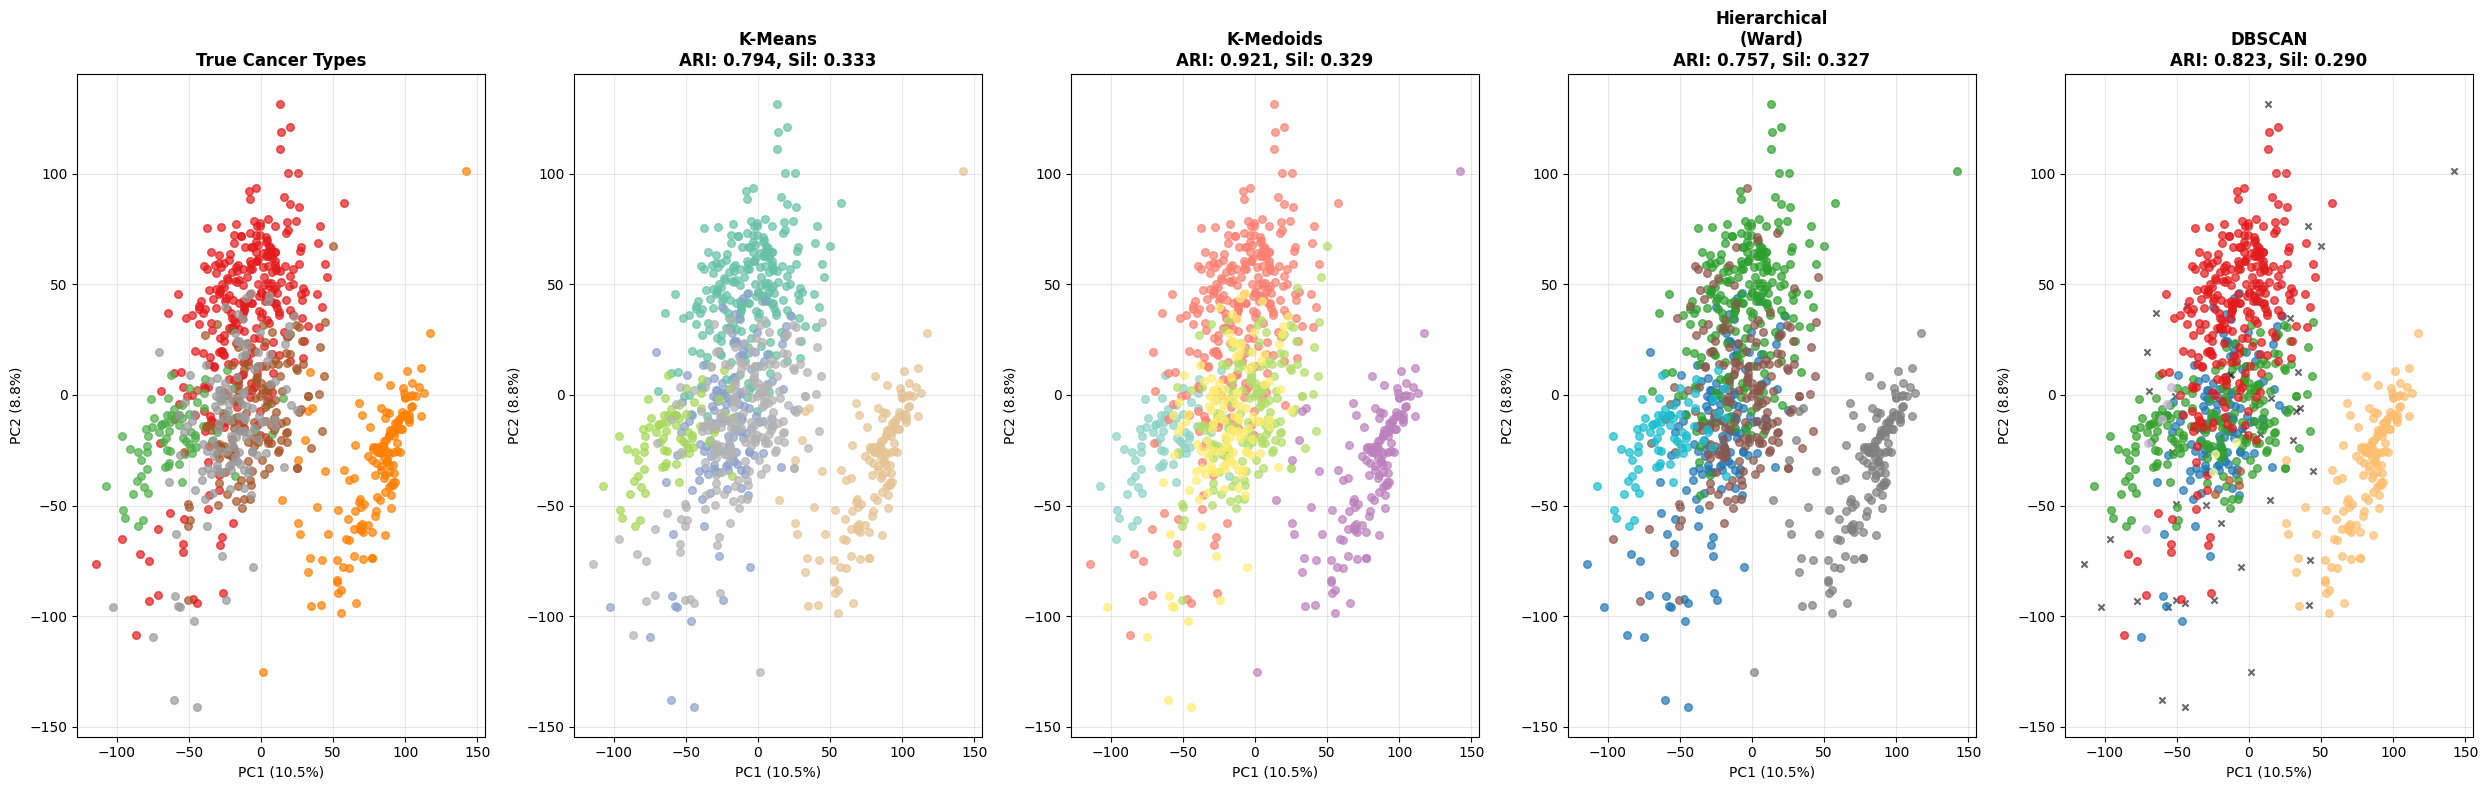

In [44]:
# Apply multiple clustering algorithms on PCA-reduced data

# Apply different clustering algorithms on PCA data
results_pca = {}

# K-Means (already computed)
results_pca['K-Means'] = labels_pca

# K-Medoids
kmed_pca = kmedoids.KMedoids(n_clusters=n_clusters, random_state=42)
euclidean_dist_pca = pairwise_distances(X_pca, metric='euclidean')
kmed_pca.fit(euclidean_dist_pca)
results_pca['K-Medoids'] = kmed_pca.labels_

# Hierarchical Clustering (Ward)
ward_pca = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
results_pca['Hierarchical\n(Ward)'] = ward_pca.fit_predict(X_pca)

# DBSCAN - use a reasonable eps value for PCA space
dbscan_pca = DBSCAN(eps=50, min_samples=3)
results_pca['DBSCAN'] = dbscan_pca.fit_predict(X_pca)

# Calculate performance metrics for each algorithm
algorithms = ['K-Means', 'K-Medoids', 'Hierarchical\n(Ward)', 'DBSCAN']
for alg in algorithms:
    ari = adjusted_rand_score(y_true, results_pca[alg])
    # Handle DBSCAN noise points for silhouette score
    if -1 in results_pca[alg]:
        mask = results_pca[alg] != -1
        if mask.sum() > 1:  # Need at least 2 points for silhouette
            sil = silhouette_score(X_pca[mask], results_pca[alg][mask])
        else:
            sil = -1  # Invalid
    else:
        sil = silhouette_score(X_pca, results_pca[alg])
    print(f"   {alg.replace(chr(10), ' '):<15}: ARI = {ari:.3f}, Silhouette = {sil:.3f}")

# Create visualization
fig, axes = plt.subplots(1, 5, figsize=(25, 8))

# Plot 1: True cancer types
for i, cancer_type in enumerate(unique_true):
    mask = y_true == cancer_type
    axes[0].scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                   c=[colors[i]], alpha=0.7, s=30)

axes[0].set_title('True Cancer Types', fontweight='bold', fontsize=12)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%})')
axes[0].grid(True, alpha=0.3)

# Plot 2-5: Clustering results
color_maps = [plt.cm.Set2, plt.cm.Set3, plt.cm.tab10, plt.cm.Paired]

for idx, algorithm in enumerate(algorithms):
    ax = axes[idx + 1]
    labels = results_pca[algorithm]
    
    # Calculate metrics for title
    ari = adjusted_rand_score(y_true, labels)
    if -1 in labels:
        mask = labels != -1
        if mask.sum() > 1:
            sil = silhouette_score(X_pca[mask], labels[mask])
        else:
            sil = -1
    else:
        sil = silhouette_score(X_pca, labels)
    
    # Plot clusters
    unique_labels = np.unique(labels)
    colors_alg = color_maps[idx](np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        if label == -1:  # Noise points in DBSCAN
            mask = labels == label
            ax.scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                      c='black', marker='x', s=20, alpha=0.6)
        else:
            mask = labels == label
            ax.scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1], 
                      c=[colors_alg[i]], alpha=0.7, s=30)
    
    ax.set_title(f'{algorithm}\nARI: {ari:.3f}, Sil: {sil:.3f}', 
                fontweight='bold', fontsize=12)
    ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

TODO: evtl change this to one plot for each method (k-means & medoids, hierarchical and dbscan)

## Overview

**K-Means/K-Medoids:**
- **Best for**: Patient stratification when you know the number of groups (e.g., risk categories)
- **Advantage**: Fast, scalable for large patient databases
- **Use case**: Creating risk groups, treatment cohorts, or diagnostic categories

**Hierarchical Clustering:**
- **Best for**: Understanding patient relationships and creating clinical decision trees
- **Advantage**: Visual dendrogram shows how patient groups relate to each other
- **Use case**: Identifying disease subtypes or treatment response patterns

**DBSCAN:**
- **Best for**: Discovering unknown patient subgroups and identifying outliers
- **Advantage**: Finds rare patient types and unusual cases automatically
- **Use case**: Detecting rare diseases, unusual treatment responses, or data quality issues

**Clinical Recommendation**: Start with hierarchical clustering for exploration, use K-means for known categories, apply DBSCAN for outlier detection.

---